# bnrs_analysis: modelling

## setup

Suggested (conda) environment setup:

```bash
conda create -n bnrs_analysis \
  python=3.11 \
  r-base=4.4.3 \
  r-essentials \
  r-lme4 \
  r-matrix \
  r-performance \
  r-insight \
  r-ordinal \
  r-mumin \
  rpy2 \
  numpy \
  pandas \
  matplotlib \
  seaborn \
  tabulate \
  scipy \
  scikit-learn \
  statsmodels \
  -c conda-forge
conda activate bnrs_analysis

## imports

In [1]:
import os # for os ops
import re # for regex
import json # for json
import numpy as np # for arrays
import pandas as pd # for dataframes
from scipy import stats #
from tabulate import tabulate # for pretty tables
from matplotlib import pyplot as plt # for plotting
import seaborn as sns # for advanced plotting
from sklearn.metrics.pairwise import cosine_similarity

# M0: One-way ANOVA models
import statsmodels.api as sm # for statsmodels
from statsmodels.formula.api import ols # for OLS models
from statsmodels.stats.anova import anova_lm # for ANOVA tables

# M1,M2,M3,M5: Mixed-effects models via rpy2 
import rpy2.robjects as robjects # for rpy2
from rpy2.robjects import pandas2ri, r # for rpy2 pandas conversion
from rpy2.robjects.packages import importr # for r package import
import rpy2.robjects.packages as rpackages # for r package ops

## load data

In [2]:
proc_dir = 'data/processed'

# load HxRyRz_recs.json
with open(os.path.join(proc_dir, 'HxRyRz_recs.json'), 'r', encoding='utf8') as f:
    HxRyRz_recs = json.load(f)

# load transitions.json (saved as lists) -> convert inner lists to tuples
with open(os.path.join(proc_dir, 'transitions.json'), 'r', encoding='utf8') as f:
    raw_transitions = json.load(f)
transitions = {strat: [tuple(item) for item in lst] for strat, lst in raw_transitions.items()}

# load dataframes
model_df = pd.read_csv(os.path.join(proc_dir, 'model_df.csv'))
supplement_df = pd.read_csv(os.path.join(proc_dir, 'supplement_df.csv'))

print('Loaded: HxRyRz_recs, transitions, model_df, supplement_df')

Loaded: HxRyRz_recs, transitions, model_df, supplement_df


## data diagnostics

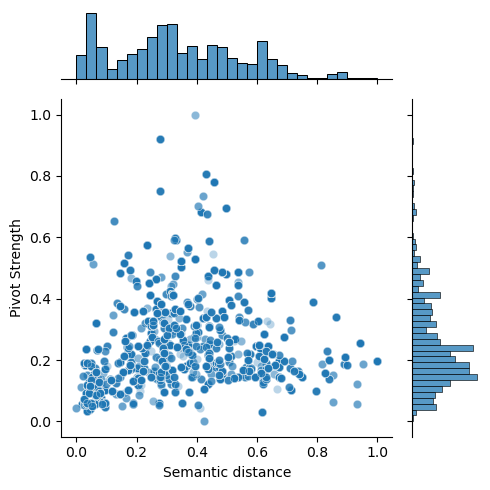

Correlation: 0.187
VIF Distance: 2.62, VIF pivot: 2.62


In [3]:
# Create joint plot
g = sns.jointplot(data=model_df, x='document_distance', y='pivot_score', 
                  alpha=0.3, height=5, ratio=4, space=0)
g.set_axis_labels('Semantic distance', 'Pivot Strength')
#g.fig.suptitle('Joint Distribution of Predictors', y=1.00)
plt.tight_layout()
plt.show()

# Check correlation between predictors
correlation = model_df[['document_distance', 'pivot_score']].corr()
print(f"Correlation: {correlation.iloc[0,1]:.3f}")

# VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = model_df[['document_distance', 'pivot_score']]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(f"VIF Distance: {vif[0]:.2f}, VIF pivot: {vif[1]:.2f}")

# RQ0: ALGORITHM VALIDATION

### Objective

Validate that our approach generated the intended semantic characteristics across recommendation types. 

---

## Model 0A: Text Distance Distribution Validation

### Overview

**Model Type:** One-way Analysis of Variance (ANOVA) with post-hoc pairwise comparisons and Bonferroni correction.

### Model Specification

```
Semantic Distance ~ Recommendation Type + ε
```

Where `ε` represents random error, assumed to be independently and identically distributed as `N(0, σ²)`.

### Variables

#### Dependent Variable
- **`semantic_distance`** - Cosine distance between candidate and reference article embeddings (continuous, 0-1 scale):

#### Independent Variable
- **`recommendation_type`** - Categorical factor with 4 levels:
  -  `random_recs` - Random recommendations  
  - `similarity_recs` - Similarity-based recommendations
  - `subject_pivot_recs` - Subject-pivoted recommendations
  - `context_pivot_recs` - Context-pivoted recommendations

### Implementation Details

| Component | Method/Package |
|-----------|----------------|
| **Package** | `statsmodels` (Python) |
| **ANOVA** | `statsmodels.formula.api.ols()` with `statsmodels.stats.anova.anova_lm()` |
| **Post-hoc tests** | Pairwise t-tests with Bonferroni correction (α = 0.05/5 = 0.01) |
| **Effect size** | Eta-squared (η²) |

### Hypotheses

| Hypothesis | Comparison | Expected Result |
|------------|------------|-----------------|
| **H0a1** | Random > Subject Pivot | Significantly higher semantic distance |
| **H0a2** | Random > Context Pivot | Significantly higher semantic distance |
| **H0a3** | Subject Pivot > Similarity | Significantly higher semantic distance |
| **H0a4** | Context Pivot > Similarity | Significantly higher semantic distance |
| **H0a5** | Subject Pivot ≈ Context Pivot | No significant difference |

In [4]:
def model_0a_distance_validation(transitions):
    """
    Model 0A: Text Distance Distribution Validation
    One-way ANOVA followed by pairwise t-tests with Bonferroni correction
    """
    
    # Prepare data
    data_list = []
    for strategy, transition_list in transitions.items():
        distances = [dist for _, _, dist, _, _, _ in transition_list]
        for distance in distances:
            data_list.append({'distance': distance, 'strategy': strategy})
    
    df = pd.DataFrame(data_list)
    
    print("Model 0A: Text Distance Distribution Validation")
    print("=" * 60)
    
    # Descriptive statistics
    print("\nDescriptive Statistics:")
    print("-" * 40)
    desc_stats = df.groupby('strategy')['distance'].agg(['mean', 'std', 'count'])
    for strategy, row in desc_stats.iterrows():
        print(f"{strategy:20}: M = {row['mean']:.4f}, SD = {row['std']:.4f}, n = {int(row['count'])}")
    
    # Check assumptions
    print("\nAssumption Checks:")
    print("-" * 40)
    
    # Normality test (Shapiro-Wilk on residuals)
    model_temp = ols('distance ~ C(strategy)', data=df).fit()
    _, p_normality = stats.shapiro(model_temp.resid)
    print(f"Normality (Shapiro-Wilk p-value): {p_normality:.6f}")
    
    # Homogeneity of variance (Levene's test)
    groups = [group['distance'].values for name, group in df.groupby('strategy')]
    _, p_levene = stats.levene(*groups)
    print(f"Homogeneity of variance (Levene's p-value): {p_levene:.6f}")
    
    # Overall ANOVA
    print("\n1. One-way ANOVA:")
    print("-" * 40)
    
    model = ols('distance ~ C(strategy)', data=df).fit()
    anova_table = anova_lm(model, typ=2)
    
    f_stat = anova_table.loc['C(strategy)', 'F']
    p_value = anova_table.loc['C(strategy)', 'PR(>F)']
    eta_squared = anova_table.loc['C(strategy)', 'sum_sq'] / anova_table['sum_sq'].sum()
    
    print(f"F({anova_table.loc['C(strategy)', 'df']:.0f}, {anova_table.loc['Residual', 'df']:.0f}) = {f_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Effect size (η²): {eta_squared:.4f}")
    
    # Pairwise comparisons - CORRECTED to match specification
    print("\n2. Pairwise Comparisons (t-tests with Bonferroni correction):")
    print("-" * 40)
    
    # Define comparisons according to the 5 specified hypotheses
    comparisons = [
        ('random_recs', 'subject_pivot_recs', 'Random > Subject Pivot'),      # H0a1
        ('random_recs', 'context_pivot_recs', 'Random > Context Pivot'),      # H0a2
        ('subject_pivot_recs', 'similarity_recs', 'Subject Pivot > Similarity'), # H0a3
        ('context_pivot_recs', 'similarity_recs', 'Context Pivot > Similarity'), # H0a4
        ('subject_pivot_recs', 'context_pivot_recs', 'Subject Pivot ≈ Context Pivot') # H0a5
    ]
    
    # CORRECTED: Bonferroni correction for 5 hypotheses
    alpha_bonf = 0.05 / len(comparisons)  # 0.05 / 5 = 0.01
    print(f"Bonferroni-adjusted alpha: {alpha_bonf:.4f}")
    
    comparison_results = {}
    
    for group1, group2, expectation in comparisons:
        # Get data for each group
        data1 = df[df['strategy'] == group1]['distance'].values
        data2 = df[df['strategy'] == group2]['distance'].values
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=True)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                             (len(data2) - 1) * np.var(data2, ddof=1)) / 
                            (len(data1) + len(data2) - 2))
        cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
        
        # Store results
        comparison_results[f"{group1} vs {group2}"] = {
            't_stat': t_stat,
            'p_value': p_val,
            'p_bonf': p_val * len(comparisons),  # Bonferroni-adjusted p-value
            'cohens_d': cohens_d,
            'mean_diff': np.mean(data1) - np.mean(data2)
        }
        
        # Display results
        print(f"\n{group1} vs {group2}:")
        print(f"  Expected: {expectation}")
        print(f"  Mean difference: {np.mean(data1) - np.mean(data2):.4f}")
        print(f"  t({len(data1) + len(data2) - 2}) = {t_stat:.3f}")
        print(f"  p-value: {p_val:.6f}")
        print(f"  Bonferroni p-value: {min(p_val * len(comparisons), 1.0):.6f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
        
        # Interpretation
        if min(p_val * len(comparisons), 1.0) < 0.05:
            if 'Subject Pivot ≈ Context Pivot' in expectation:
                interpretation = "Unexpected significant difference"
            else:
                if np.mean(data1) > np.mean(data2):
                    interpretation = "Hypothesis supported"
                else:
                    interpretation = "Hypothesis not supported (opposite direction)"
        else:
            if 'Subject Pivot ≈ Context Pivot' in expectation:
                interpretation = "No significant difference (as expected)"
            else:
                interpretation = "No significant difference"
        
        print(f"  Interpretation: {interpretation}")
    
    print(f"\n3. Summary:")
    print("-" * 40)
    print("Expected hierarchy: Random > Subject/Context > Similarity")
    print("Expected equivalence: Subject ≈ Context")
    
    return {
        'model': model,
        'anova_table': anova_table,
        'f_stat': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'descriptive_stats': desc_stats,
        'comparison_results': comparison_results,
        'bonferroni_alpha': alpha_bonf,
        'assumptions': {
            'normality_p': p_normality,
            'levene_p': p_levene
        }
    }
model_0a_results = model_0a_distance_validation(transitions)

Model 0A: Text Distance Distribution Validation

Descriptive Statistics:
----------------------------------------
context_pivot_recs  : M = 0.2673, SD = 0.0841, n = 125
random_recs         : M = 0.4529, SD = 0.1205, n = 125
similarity_recs     : M = 0.1012, SD = 0.0658, n = 125
subject_pivot_recs  : M = 0.2760, SD = 0.0925, n = 125

Assumption Checks:
----------------------------------------
Normality (Shapiro-Wilk p-value): 0.000007
Homogeneity of variance (Levene's p-value): 0.000000

1. One-way ANOVA:
----------------------------------------
F(3, 496) = 299.2611
p-value: 0.000000
Effect size (η²): 0.6441

2. Pairwise Comparisons (t-tests with Bonferroni correction):
----------------------------------------
Bonferroni-adjusted alpha: 0.0100

random_recs vs subject_pivot_recs:
  Expected: Random > Subject Pivot
  Mean difference: 0.1769
  t(248) = 13.013
  p-value: 0.000000
  Bonferroni p-value: 0.000000
  Cohen's d: 1.646
  Interpretation: Hypothesis supported

random_recs vs context

## Model 0B: pivot Score Validation

### Overview

**Model Type:** One-way Analysis of Variance (ANOVA) with post-hoc pairwise comparisons and Bonferroni correction.

### Model Specification

```
pivot Score ~ Recommendation Type + ε
```

Where `ε` represents random error, assumed to be independently and identically distributed as `N(0, σ²)`.

### Variables

#### Dependent Variable
- **`pivot_score`** - pivot score for recommendations
  - Type: Continuous

#### Independent Variable
- **`recommendation_type`** - Categorical factor with 4 levels:
  - `random_recs` - Random recommendations  
  - `similarity_recs` - Similarity-based recommendations
  - `subject_pivot_recs` - Subject-pivoted recommendations
  - `context_pivot_recs` - Context-pivoted recommendations

### Implementation Details

| Component | Method/Package |
|-----------|----------------|
| **Package** | `statsmodels` (Python) |
| **ANOVA** | `statsmodels.formula.api.ols()` with `statsmodels.stats.anova.anova_lm()` |
| **Post-hoc tests** | Pairwise t-tests with Bonferroni correction (α = 0.05/4 = 0.0125) |
| **Effect size** | Eta-squared (η²) |

### Hypotheses

| Hypothesis | Comparison | Expected Result |
|------------|------------|-----------------|
| **H0b1** | Subject Pivot > Random | Significantly higher pivot score |
| **H0b2** | Context Pivot > Random | Significantly higher pivot score |
| **H0b3** | Random > Similarity | Significantly higher pivot score |
| **H0b4** | Subject Pivot ≈ Context Pivot | No significant difference |


In [5]:
def model_0b_pivot_validation(transitions):
    """
    Model 0B: pivot Score Distribution Validation
    One-way ANOVA followed by pairwise t-tests with Bonferroni correction
    """
    
    # Prepare data - using 6th element (pivot score) instead of 3rd (distance)
    data_list = []
    for strategy, transition_list in transitions.items():
        ff_scores = [ff_score for _, _, _, _, _, ff_score in transition_list]
        for ff_score in ff_scores:
            data_list.append({'pivot': ff_score, 'strategy': strategy})
    
    df = pd.DataFrame(data_list)
    
    print("Model 0B: pivot Score Distribution Validation")
    print("=" * 60)
    
    # Descriptive statistics
    print("\nDescriptive Statistics:")
    print("-" * 40)
    desc_stats = df.groupby('strategy')['pivot'].agg(['mean', 'std', 'count'])
    for strategy, row in desc_stats.iterrows():
        print(f"{strategy:20}: M = {row['mean']:.4f}, SD = {row['std']:.4f}, n = {int(row['count'])}")
    
    # Check assumptions
    print("\nAssumption Checks:")
    print("-" * 40)
    
    # Normality test (Shapiro-Wilk on residuals)
    model_temp = ols('pivot ~ C(strategy)', data=df).fit()
    _, p_normality = stats.shapiro(model_temp.resid)
    print(f"Normality (Shapiro-Wilk p-value): {p_normality:.6f}")
    
    # Homogeneity of variance (Levene's test)
    groups = [group['pivot'].values for name, group in df.groupby('strategy')]
    _, p_levene = stats.levene(*groups)
    print(f"Homogeneity of variance (Levene's p-value): {p_levene:.6f}")
    
    # Overall ANOVA
    print("\n1. One-way ANOVA:")
    print("-" * 40)
    
    model = ols('pivot ~ C(strategy)', data=df).fit()
    anova_table = anova_lm(model, typ=2)
    
    f_stat = anova_table.loc['C(strategy)', 'F']
    p_value = anova_table.loc['C(strategy)', 'PR(>F)']
    eta_squared = anova_table.loc['C(strategy)', 'sum_sq'] / anova_table['sum_sq'].sum()
    
    print(f"F({anova_table.loc['C(strategy)', 'df']:.0f}, {anova_table.loc['Residual', 'df']:.0f}) = {f_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Effect size (η²): {eta_squared:.4f}")
    
    # Pairwise comparisons
    print("\n2. Pairwise Comparisons (t-tests with Bonferroni correction):")
    print("-" * 40)
    
    # Define comparisons based on specification: 
    comparisons = [
        ('subject_pivot_recs', 'random_recs', 'Subject > Random'),
        ('context_pivot_recs', 'random_recs', 'Context > Random'),
        ('random_recs', 'similarity_recs', 'Random > Similarity'),
        ('subject_pivot_recs', 'context_pivot_recs', 'Subject ≈ Context')
    ]
    
    alpha_bonf = 0.05 / len(comparisons)
    print(f"Bonferroni-adjusted alpha: {alpha_bonf:.4f}")
    
    comparison_results = {}
    
    for group1, group2, expectation in comparisons:
        # Get data for each group
        data1 = df[df['strategy'] == group1]['pivot'].values
        data2 = df[df['strategy'] == group2]['pivot'].values
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=True)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                             (len(data2) - 1) * np.var(data2, ddof=1)) / 
                            (len(data1) + len(data2) - 2))
        cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
        
        # Store results
        comparison_results[f"{group1} vs {group2}"] = {
            't_stat': t_stat,
            'p_value': p_val,
            'p_bonf': p_val * len(comparisons),  # Bonferroni-adjusted p-value
            'cohens_d': cohens_d,
            'mean_diff': np.mean(data1) - np.mean(data2)
        }
        
        # Display results
        print(f"\n{group1} vs {group2}:")
        print(f"  Expected: {expectation}")
        print(f"  Mean difference: {np.mean(data1) - np.mean(data2):.4f}")
        print(f"  t({len(data1) + len(data2) - 2}) = {t_stat:.3f}")
        print(f"  p-value: {p_val:.6f}")
        print(f"  Bonferroni p-value: {min(p_val * len(comparisons), 1.0):.6f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
        
        # Interpretation
        if min(p_val * len(comparisons), 1.0) < 0.05:
            if 'Subject ≈ Context' in expectation:
                interpretation = "Unexpected significant difference"
            else:
                if np.mean(data1) > np.mean(data2):
                    interpretation = "Hypothesis supported"
                else:
                    interpretation = "Hypothesis not supported (opposite direction)"
        else:
            if 'Subject ≈ Context' in expectation:
                interpretation = "No significant difference (as expected)"
            else:
                interpretation = "No significant difference"
        
        print(f"  Interpretation: {interpretation}")
    
    print(f"\n3. Summary:")
    print("-" * 40)
    print("Expected hierarchy: Subject/Context > Random > Similarity")
    print("Expected equivalence: Subject ≈ Context")
    
    return {
        'model': model,
        'anova_table': anova_table,
        'f_stat': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'descriptive_stats': desc_stats,
        'comparison_results': comparison_results,
        'bonferroni_alpha': alpha_bonf,
        'assumptions': {
            'normality_p': p_normality,
            'levene_p': p_levene
        }
    }
model_0b_results = model_0b_pivot_validation(transitions)

Model 0B: pivot Score Distribution Validation

Descriptive Statistics:
----------------------------------------
context_pivot_recs  : M = 0.3378, SD = 0.1555, n = 125
random_recs         : M = 0.2009, SD = 0.0808, n = 125
similarity_recs     : M = 0.1765, SD = 0.1411, n = 125
subject_pivot_recs  : M = 0.2618, SD = 0.1425, n = 125

Assumption Checks:
----------------------------------------
Normality (Shapiro-Wilk p-value): 0.000000
Homogeneity of variance (Levene's p-value): 0.000000

1. One-way ANOVA:
----------------------------------------
F(3, 496) = 36.4814
p-value: 0.000000
Effect size (η²): 0.1808

2. Pairwise Comparisons (t-tests with Bonferroni correction):
----------------------------------------
Bonferroni-adjusted alpha: 0.0125

subject_pivot_recs vs random_recs:
  Expected: Subject > Random
  Mean difference: 0.0609
  t(248) = 4.158
  p-value: 0.000044
  Bonferroni p-value: 0.000177
  Cohen's d: 0.526
  Interpretation: Hypothesis supported

context_pivot_recs vs random_rec

# RQ1: BASELINE MODELS (H1a, H1b, H1c)
---

## M1a: Baseline Distance Effect - Evaluation


### Overview
**Model Type:** Mixed-effects ordinal logistic regression.

### Model Specification
```
{rel/unx/sat}_rank_reversed ~ document_distance + pivot_score + round + (1|initial_article)
```
Where `{rel/unx/sat}_rank_reversed` represents three separate models for relevance, surprise, and satisfaction rankings.

### Variables
#### Dependent Variables
- **`rel_rank_reversed`** - Relevance ranking (ordinal: 4=most relevant, 3, 2, 1=least relevant)
- **`unx_rank_reversed`** - Surprise ranking (ordinal: 4=most surprising, 3, 2, 1=least surprising)  
- **`sat_rank_reversed`** - Satisfaction ranking (ordinal: 4=most satisfying, 3, 2, 1=least satisfying)

#### Fixed Effects
- **`document_distance`** - Primary predictor: semantic distance between candidate and reference article
- **`pivot_score`** - Control variable: normalized pivot score (to avoid confounding)
- **`round`** - Control variable: round-specific differences (round 1 vs round 2)

#### Random Effects
- **`(1|initial_article)`** - Accounts for headline selection effects

### Implementation Details
| Component | Method/Package |
|-----------|----------------|
| **Package** | `ordinal` (R) |
| **Method** | `ordinal::clmm()` - Mixed-effects ordinal logistic regression |
| **Models** | Three separate models (one per dependent variable) |

### Hypotheses
| Hypothesis | Variable | Relevance | Surprise | Satisfaction |
|------------|----------|-----------|----------|--------------|
| **H1a** | Semantic Distance | Negative coefficient | Negative coefficient | Negative coefficient |

In [6]:
def model_1a_fit_evaluation_baseline(model_df):
    """
    Model 1A FIT: Baseline Distance Effect on User Rankings (controlling for pivot)
    Mixed-effects ordinal logistic regression using R's ordinal::clmm() via rpy2
    
    Specification:
    User Ranking ~ Document Distance + pivot + Round + (1|Initial_Article)
    
    Returns:
    dict: Raw model results and coefficients for each ranking dimension
    """
    
    print("Model 1A FIT: Baseline Distance Effect - Item Evaluations")
    print("=" * 60)
    print("Fitting mixed-effects ordinal logistic regression models...")
    print()
    
    # Define the three ranking dimensions
    ranking_dimensions = ['rel_rank_reversed', 'unx_rank_reversed', 'sat_rank_reversed']
    
    results = {}
    fit_status = {}
    
    # START rpy2 conversion context for all R operations:
    with (robjects.default_converter + pandas2ri.converter).context():
        try:
            base = importr('base') # for r base functions
            utils = importr('utils') # for r utils functions
            ordinal = importr('ordinal') # for ordinal models
            performance = importr('performance') # for nakagawa r2
        except Exception as e:
            print("Error: Required R packages not available. Please install 'ordinal' and 'performance' packages in R.")
            print("install.packages(c('ordinal', 'performance'))")
            raise e

        # Fit models for each ranking dimension
        for dimension in ranking_dimensions:
            dim_name = dimension.replace('_rank_reversed', '')
            print(f"Fitting {dim_name.upper()} model...", end=" ")
            
            # Prepare data - remove any missing values for this dimension
            analysis_df = model_df.dropna(subset=[dimension, 'document_distance', 'pivot_score', 
                                                'participant_id', 'round', 'initial_article'])
            
            # Convert ranking to ordered factor and handle problematic columns
            analysis_df[dimension] = analysis_df[dimension].astype(str)
            
            # Convert large integer columns to string to avoid rpy2 warnings
            for col in ['initial_article', 'from_article_id', 'to_article_id']:
                if col in analysis_df.columns:
                    analysis_df[col] = analysis_df[col].astype(str)
            
            # Ensure other categorical variables are strings
            analysis_df['participant_id'] = analysis_df['participant_id'].astype(str)
            analysis_df['round'] = analysis_df['round'].astype(str)
            
            try:
                # Convert to R dataframe
                r_df = robjects.conversion.py2rpy(analysis_df)
                robjects.globalenv['analysis_data'] = r_df
                
                # Fit ordinal mixed-effects model using clmm()
                formula_str = f"{dimension} ~ document_distance + pivot_score + round + (1|initial_article)"
                
                r_code = f"""
                library(ordinal)
                library(performance)
                
                # Ensure ranking is ordered factor with proper levels
                analysis_data${dimension} <- factor(analysis_data${dimension}, levels=c("1","2","3","4"), ordered=TRUE)
                
                # Ensure grouping variables are factors
                analysis_data$round <- factor(analysis_data$round)
                analysis_data$initial_article <- factor(analysis_data$initial_article)
                
                # Fit model
                model <- clmm({formula_str}, data=analysis_data, link="logit")
                
                # Get summary
                model_summary <- summary(model)
                model_summary
                """
                
                # Execute R code
                model_result = r(r_code)
                
                # Extract coefficients
                coef_code = """
                # Extract coefficients as named vectors for easier extraction
                coef_est <- model_summary$coefficients[,"Estimate"]
                coef_se <- model_summary$coefficients[,"Std. Error"] 
                coef_z <- model_summary$coefficients[,"z value"]
                coef_p <- model_summary$coefficients[,"Pr(>|z|)"]
                coef_names <- rownames(model_summary$coefficients)
                
                # Create a list to return
                list(estimates = coef_est, 
                     std_errors = coef_se,
                     z_values = coef_z,
                     p_values = coef_p,
                     names = coef_names)
                """
                
                coef_result = r(coef_code)
                
                # Extract fit statistics including R-squared
                fit_stats_code = """
                # Extract model fit statistics
                aic_val <- AIC(model)
                bic_val <- BIC(model)
                loglik_val <- logLik(model)
                
                # Calculate R-squared using performance package
                r2_results <- r2_nakagawa(model)
                conditional_r2 <- r2_results$R2_conditional
                marginal_r2 <- r2_results$R2_marginal
                
                # Create list with fit statistics
                list(aic = aic_val,
                     bic = bic_val,
                     loglik = as.numeric(loglik_val),
                     conditional_r2 = conditional_r2,
                     marginal_r2 = marginal_r2)
                """
                
                fit_stats_result = r(fit_stats_code)
                
                # Convert to Python lists for easier handling
                coef_names = list(coef_result[4])
                coef_estimates = list(coef_result[0])
                coef_se = list(coef_result[1])
                coef_z = list(coef_result[2])
                coef_p = list(coef_result[3])

                # Extract fit statistics
                aic_val = float(fit_stats_result[0][0])
                bic_val = float(fit_stats_result[1][0])
                loglik_val = float(fit_stats_result[2][0])
                conditional_r2 = float(fit_stats_result[3][0])
                marginal_r2 = float(fit_stats_result[4][0])
                
                # Create a dictionary for easy lookup
                coef_dict = {}
                for i, name in enumerate(coef_names):
                    coef_dict[name] = {
                        'estimate': coef_estimates[i],
                        'std_error': coef_se[i], 
                        'z_value': coef_z[i],
                        'p_value': coef_p[i]
                    }
                
                # Store results
                results[dim_name] = {
                    'r_model': model_result,
                    'coefficient_dict': coef_dict,
                    'fit_statistics': {
                        'aic': aic_val,
                        'bic': bic_val,
                        'loglik': loglik_val,
                        'conditional_r2': conditional_r2,
                        'marginal_r2': marginal_r2
                    },
                    'n_obs': len(analysis_df),
                    'n_participants': analysis_df['participant_id'].nunique(),
                    'n_rounds': analysis_df['round'].nunique(),
                    'n_initial_articles': analysis_df['initial_article'].nunique(),
                    'formula': formula_str,
                    'dimension': dimension
                }
                
                fit_status[dim_name] = "SUCCESS"
                print("✓ SUCCESS")
                
            except Exception as e:
                print(f"✗ FAILED: {e}")
                results[dim_name] = None
                fit_status[dim_name] = f"FAILED: {e}"
    
    # Summary of fitting results (outside context is fine - just printing)
    print(f"\nFITTING SUMMARY:")
    print("-" * 40)
    for dim_name in ['rel', 'unx', 'sat']:
        status = fit_status[dim_name]
        print(f"{dim_name}_ranking: {status}")
        
        # Print fit statistics if successful
        if status == "SUCCESS" and results[dim_name] is not None:
            fit_stats = results[dim_name]['fit_statistics']
            print(f"  AIC: {fit_stats['aic']:.2f}, BIC: {fit_stats['bic']:.2f}, LogLik: {fit_stats['loglik']:.2f}")
            print(f"  R²_conditional: {fit_stats['conditional_r2']:.3f}, R²_marginal: {fit_stats['marginal_r2']:.3f}")
    
    successful_fits = sum(1 for status in fit_status.values() if status == "SUCCESS")
    print(f"\nSuccessful fits: {successful_fits}/3")
    
    return {
        'results': results,
        'fit_status': fit_status,
        'model_type': 'baseline_evaluation',
        'specification': 'User Ranking ~ Document Distance + pivot + Round + (1|Initial_Article)'
    }
model_1a_fitted = model_1a_fit_evaluation_baseline(model_df)

Model 1A FIT: Baseline Distance Effect - Item Evaluations
Fitting mixed-effects ordinal logistic regression models...

Fitting REL model... ✓ SUCCESS
Fitting UNX model... ✓ SUCCESS
Fitting SAT model... ✓ SUCCESS

FITTING SUMMARY:
----------------------------------------
rel_ranking: SUCCESS
  AIC: 13515.12, BIC: 13561.85, LogLik: -6750.56
  R²_conditional: 0.430, R²_marginal: 0.411
unx_ranking: SUCCESS
  AIC: 15696.69, BIC: 15743.41, LogLik: -7841.34
  R²_conditional: 0.099, R²_marginal: 0.097
sat_ranking: SUCCESS
  AIC: 14719.77, BIC: 14766.50, LogLik: -7352.89
  R²_conditional: 0.260, R²_marginal: 0.251

Successful fits: 3/3


In [7]:
def model_1a_report_evaluation_baseline(fit_results):
    """
    Model 1A REPORT: Interpret baseline distance effects on user rankings
    
    Takes fitted model results and provides comprehensive interpretation
    
    Parameters:
    fit_results (dict): Output from model_1a_fit_evaluation_baseline()
    
    Returns:
    dict: Interpreted results with hypothesis tests and practical impacts
    """
    
    print("Model 1A REPORT: Baseline Distance Effect - Item Evaluations")
    print("=" * 70)
    print("Interpreting fitted mixed-effects ordinal logistic regression results")
    print("Ranking scale: 4=best, 3, 2, 1=worst")
    print()
    
    if fit_results['fit_status'] is None:
        print("ERROR: No fitted results to report")
        return None
    
    results = fit_results['results']
    interpreted_results = {}
    
    # PUBLICATION-READY REGRESSION TABLE
    print("REGRESSION TABLE")
    print("-" * 70)
    print()
    
    # Prepare table data
    dimensions = ['rel', 'unx', 'sat']
    
    # Get all unique coefficient names across dimensions
    all_coef_names = set()
    for dim_name in dimensions:
        if results[dim_name] is not None:
            all_coef_names.update(results[dim_name]['coefficient_dict'].keys())
    
    # Filter and order coefficient names (exclude threshold parameters)
    ordered_coef_names = []
    for name in ['document_distance', 'pivot_score', 'round2']:
        if name in all_coef_names:
            ordered_coef_names.append(name)
    
    # Add any remaining coefficients (exclude thresholds)
    for name in sorted(all_coef_names):
        if name not in ordered_coef_names and not name.startswith(('1|', '2|', '3|', '4|')):
            ordered_coef_names.append(name)
    
    # Prepare table data
    table_data = []
    
    for coef_name in ordered_coef_names:
        # Clean variable name for display
        display_name = coef_name.replace('document_distance', 'Document Distance')\
                               .replace('pivot_score', 'FF Score')\
                               .replace('round2', 'Round 2')
        
        row = [display_name]
        
        for dim_name in dimensions:
            if results[dim_name] is not None and coef_name in results[dim_name]['coefficient_dict']:
                coef_dict = results[dim_name]['coefficient_dict'][coef_name]
                beta = coef_dict['estimate']
                se = coef_dict['std_error']
                p_val = coef_dict['p_value']
                
                # Calculate 95% confidence interval
                ci_lower = beta - 1.96 * se
                ci_upper = beta + 1.96 * se
                
                # Format coefficient and CI
                coef_str = f"{beta:.3f}"
                ci_str = f"[{ci_lower:.3f}, {ci_upper:.3f}]"
                
                # Format p-value with significance stars
                if p_val < 0.001:
                    p_str = "< .001***"
                elif p_val < 0.01:
                    p_str = f"{p_val:.3f}**"
                elif p_val < 0.05:
                    p_str = f"{p_val:.3f}*"
                else:
                    p_str = f"{p_val:.3f}"
                
                row.extend([coef_str, ci_str, p_str])
            else:
                row.extend(["—", "—", "—"])
        
        table_data.append(row)
    
    # Add sample size row
    n_obs_row = ["N (observations)"]
    for dim_name in dimensions:
        if results[dim_name] is not None:
            n_obs = results[dim_name]['n_obs']
            n_obs_row.extend([f"{n_obs:,}", "", ""])
        else:
            n_obs_row.extend(["—", "", ""])
    table_data.append(n_obs_row)
    
    # Add participant count row
    n_part_row = ["N (participants)"]
    for dim_name in dimensions:
        if results[dim_name] is not None:
            n_part = results[dim_name]['n_participants']
            n_part_row.extend([f"{n_part:,}", "", ""])
        else:
            n_part_row.extend(["—", "", ""])
    table_data.append(n_part_row)
    
    # Create headers
    headers = ["Variable", 
               "β", "95% CI", "p",      # Relevance
               "β", "95% CI", "p",      # Surprise 
               "β", "95% CI", "p"]      # Satisfaction
    
    # Print table with column headers
    print("**Mixed-Effects Ordinal Logistic Regression Results**")
    print()
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print()
    print("*Notes: *** p < .001, ** p < .01, * p < .05*")
    print("*95% confidence intervals in brackets*")
    print("*Random effects: (1|initial_article)*")
    print()
    
    # Store results for hypothesis testing
    for dim_name in ['rel', 'unx', 'sat']:
        if results[dim_name] is None:
            continue
            
        coef_dict = results[dim_name]['coefficient_dict']
        
        # Extract and interpret Document Distance results
        distance_coef = coef_dict.get('document_distance', {}).get('estimate')
        distance_se = coef_dict.get('document_distance', {}).get('std_error')
        distance_z = coef_dict.get('document_distance', {}).get('z_value')
        distance_p = coef_dict.get('document_distance', {}).get('p_value')
        distance_or = np.exp(distance_coef) if distance_coef is not None else None
        
        # Practical impact: 0.1 distance increase
        impact_01 = np.exp(distance_coef * 0.1) if distance_coef is not None else None
        
        # Extract pivot results
        ff_coef = coef_dict.get('pivot_score', {}).get('estimate')
        ff_se = coef_dict.get('pivot_score', {}).get('std_error')
        ff_z = coef_dict.get('pivot_score', {}).get('z_value')
        ff_p = coef_dict.get('pivot_score', {}).get('p_value')
        
        # Extract Round effects
        round_effects = {}
        for name in coef_dict.keys():
            if name.startswith('round'):
                round_effects[name] = coef_dict[name]
        
        # Store interpreted results
        interpreted_results[dim_name] = {
            'distance_coefficient': distance_coef,
            'distance_p_value': distance_p,
            'distance_odds_ratio': distance_or,
            'distance_impact_01': impact_01,
            'ff_coefficient': ff_coef,
            'ff_p_value': ff_p,
            'round_effects': round_effects,
            'n_obs': results[dim_name]['n_obs']
        }
    
    # HYPOTHESIS TESTING SUMMARY
    print(f"HYPOTHESIS TESTING SUMMARY")
    print("=" * 70)
    
    predictions = {
    'rel': 'Negative coefficient (higher distance → lower odds of higher relevance rankings)',
    'sat': 'Negative coefficient (higher distance → lower odds of higher satisfaction rankings)', 
    'unx': 'Negative coefficient (higher distance → lower odds of higher surprise rankings)' 
}
    
    hypothesis_results = {}
    
    for dim_name in ['rel', 'unx', 'sat']:
        if dim_name in interpreted_results and interpreted_results[dim_name]['distance_coefficient'] is not None:
            coef = interpreted_results[dim_name]['distance_coefficient']
            pval = interpreted_results[dim_name]['distance_p_value']
            
            print(f"\n**H1a - {dim_name.upper()} Rankings:**")
            print(f"  Predicted: {predictions[dim_name]}")
            print(f"  Observed: β = {coef:.4f}, p = {pval:.4f}")
            
            # Determine hypothesis support
            if pval < 0.05:
                if coef < 0:
                    result = "SUPPORTED"
                    print(f"  **Result: ✓ Hypothesis {result}**")
                else:
                    result = "NOT SUPPORTED (opposite direction)"
                    print(f"  **Result: ✗ Hypothesis {result}**")
            else:
                result = "NOT SUPPORTED (no significant effect)"
                print(f"  **Result: ~ Hypothesis {result}**")
            
            # Store for return
            hypothesis_results[f'H1a_{dim_name}'] = {
                'prediction': predictions[dim_name],
                'coefficient': coef,
                'p_value': pval,
                'result': result,
                'supported': result == "SUPPORTED"
            }
    
    print(f"\n**Overall H1a Summary:**")
    supported_count = sum(1 for h in hypothesis_results.values() if h['supported'])
    total_count = len(hypothesis_results)
    print(f"Hypotheses supported: {supported_count}/{total_count}")
    
    if supported_count == total_count:
        print("**All baseline distance hypotheses are supported**")
    elif supported_count > 0:
        print("**Partial support for baseline distance hypotheses**")
    else:
        print("**No support for baseline distance hypotheses**")
    
    return {
        'interpreted_results': interpreted_results,
        'hypothesis_results': hypothesis_results,
        'fit_results': fit_results,
        'hypothesis_predictions': predictions
    }
model_1a_results = model_1a_report_evaluation_baseline(model_1a_fitted)

Model 1A REPORT: Baseline Distance Effect - Item Evaluations
Interpreting fitted mixed-effects ordinal logistic regression results
Ranking scale: 4=best, 3, 2, 1=worst

REGRESSION TABLE
----------------------------------------------------------------------

**Mixed-Effects Ordinal Logistic Regression Results**

+-------------------+--------+------------------+-----------+--------+------------------+-----------+--------+------------------+-----------+
| Variable          | β      | 95% CI           | p         | β      | 95% CI           | p         | β      | 95% CI           | p         |
+===================+========+==================+===========+========+==================+===========+========+==================+===========+
| Document Distance | -7.114 | [-7.422, -6.807] | < .001*** | -2.820 | [-3.066, -2.573] | < .001*** | -4.925 | [-5.194, -4.656] | < .001*** |
+-------------------+--------+------------------+-----------+--------+------------------+-----------+--------+---------

## M1b: Baseline Distance Effect - Engagement 

### Overview
**Model Type:** Mixed-effects binary logistic regression.

### Model Specification
```
Item Selection ~ Document Distance + pivot + Round + (1|Initial_Article)
```

### Variables
#### Dependent Variable
- **`item_selection`** - Binary selection indicator (1 = selected, 0 = not selected)

#### Fixed Effects
- **`document_distance`** - Primary predictor: semantic distance between candidate and reference article
- **`pivot_score`** - Control variable: normalized pivot score (to avoid confounding)
- **`round`** - Control variable: round-specific differences (round 1 vs round 2)

#### Random Effects
- **`(1|initial_article)`** - Accounts for headline selection effects

### Implementation Details
| Component | Method/Package |
|-----------|----------------|
| **Package** | `lme4` (R) |
| **Method** | `lme4::glmer()` - Mixed-effects binary logistic regression |
| **Family** | `binomial(link="logit")` |

### Hypotheses
| Hypothesis | Variable | Expected Result |
|------------|----------|-----------------|
| **H1b** | Document Distance | Negative coefficient (distance hurts selection probability) |

In [8]:
def model_1b_fit_selection_baseline(model_df):
    """
    Model 1b FIT: Baseline Distance Effect on Item Selections (controlling for pivot)
    Mixed-effects binary logistic regression using R's lme4::glmer() via rpy2
    
    Specification:
    Item Selection ~ Document Distance + pivot + Round + (1|Initial_Article)
    
    Returns:
    dict: Raw model results and coefficients for selection behavior
    """
    
    print("Model 1b FIT: Baseline Distance Effect - Item Selections")
    print("=" * 60)
    print("Fitting mixed-effects binary logistic regression model...")
    print()
    
    # Prepare data - remove any missing values
    analysis_df = model_df.dropna(subset=['selected', 'document_distance', 'pivot_score', 
                                        'participant_id', 'round', 'initial_article'])
    
    print(f"Sample size: {len(analysis_df)} observations")
    print(f"Participants: {analysis_df['participant_id'].nunique()}")
    print(f"Rounds: {analysis_df['round'].nunique()}")
    print(f"Initial articles: {analysis_df['initial_article'].nunique()}")
    
    # Check selection distribution
    selection_counts = analysis_df['selected'].value_counts().sort_index()
    print(f"Selection distribution: Not selected = {selection_counts.get(0, 0)}, Selected = {selection_counts.get(1, 0)}")
    print()
    
    # Convert large integer columns to string to avoid rpy2 warnings
    for col in ['initial_article', 'from_article_id', 'to_article_id']:
        if col in analysis_df.columns:
            analysis_df[col] = analysis_df[col].astype(str)
    
    # Ensure categorical variables are strings
    analysis_df['participant_id'] = analysis_df['participant_id'].astype(str)
    analysis_df['round'] = analysis_df['round'].astype(str)
    
    # START rpy2 conversion context for all R operations:
    with (robjects.default_converter + pandas2ri.converter).context():
        try:
            base = importr('base')  # for r base functions
            utils = importr('utils')  # for r utils functions
            lme4 = importr('lme4')  # for mixed-effects models
            performance = importr('performance')  # for nakagawa r2
        except Exception as e:
            print("Error: Required R packages not available. Please install 'lme4' and 'performance' packages in R.")
            print("install.packages(c('lme4', 'performance'))")
            raise e
        
        # Convert to R dataframe
        r_df = robjects.conversion.py2rpy(analysis_df)
        robjects.globalenv['analysis_data'] = r_df
        
        try:
            print("Fitting binary logistic mixed-effects model...", end=" ")
            
            # Fit binary mixed-effects model using glmer()
            formula_str = "selected ~ document_distance + pivot_score + round + (1|initial_article)"
            
            r_code = f"""
            library(lme4)
            library(performance)
            
            # Ensure outcome is binary
            analysis_data$selected <- as.numeric(analysis_data$selected)
            
            # Ensure grouping variables are factors
            analysis_data$participant_id <- factor(analysis_data$participant_id)
            analysis_data$round <- factor(analysis_data$round)
            analysis_data$initial_article <- factor(analysis_data$initial_article)
            
            # Check data structure
            cat("Selection variable distribution:", table(analysis_data$selected), "\\n")
            cat("Number of participants:", nlevels(analysis_data$participant_id), "\\n")
            cat("Number of rounds:", nlevels(analysis_data$round), "\\n")
            cat("Number of initial articles:", nlevels(analysis_data$initial_article), "\\n")
            
            # Fit model
            model <- glmer({formula_str}, data=analysis_data, family=binomial(link="logit"))
            
            # Get summary
            model_summary <- summary(model)
            model_summary
            """
            
            # Execute R code
            model_result = r(r_code)
            
            # Extract coefficients
            coef_code = """
            # Extract coefficients as named vectors for easier extraction
            coef_est <- summary(model)$coefficients[,"Estimate"]
            coef_se <- summary(model)$coefficients[,"Std. Error"] 
            coef_z <- summary(model)$coefficients[,"z value"]
            coef_p <- summary(model)$coefficients[,"Pr(>|z|)"]
            coef_names <- rownames(summary(model)$coefficients)
            
            # Create a list to return
            list(estimates = coef_est, 
                 std_errors = coef_se,
                 z_values = coef_z,
                 p_values = coef_p,
                 names = coef_names)
            """
            
            coef_result = r(coef_code)
            
            # Extract fit statistics including R-squared
            fit_stats_code = """
            # Extract model fit statistics
            aic_val <- AIC(model)
            bic_val <- BIC(model)
            loglik_val <- logLik(model)
            
            # Calculate R-squared using performance package
            r2_results <- r2_nakagawa(model)
            conditional_r2 <- r2_results$R2_conditional
            marginal_r2 <- r2_results$R2_marginal
            
            # Create list with fit statistics
            list(aic = aic_val,
                 bic = bic_val,
                 loglik = as.numeric(loglik_val),
                 conditional_r2 = conditional_r2,
                 marginal_r2 = marginal_r2)
            """
            
            fit_stats_result = r(fit_stats_code)
            
            # Convert to Python lists for easier handling
            coef_names = list(coef_result[4])
            coef_estimates = list(coef_result[0])
            coef_se = list(coef_result[1])
            coef_z = list(coef_result[2])
            coef_p = list(coef_result[3])
            
            # Extract fit statistics
            aic_val = float(fit_stats_result[0][0])
            bic_val = float(fit_stats_result[1][0])
            loglik_val = float(fit_stats_result[2][0])
            conditional_r2 = float(fit_stats_result[3][0])
            marginal_r2 = float(fit_stats_result[4][0])
            
            # Create a dictionary for easy lookup
            coef_dict = {}
            for i, name in enumerate(coef_names):
                coef_dict[name] = {
                    'estimate': coef_estimates[i],
                    'std_error': coef_se[i], 
                    'z_value': coef_z[i],
                    'p_value': coef_p[i]
                }
            
            # Store results
            results = {
                'r_model': model_result,
                'coefficient_dict': coef_dict,
                'fit_statistics': {
                    'aic': aic_val,
                    'bic': bic_val,
                    'loglik': loglik_val,
                    'conditional_r2': conditional_r2,
                    'marginal_r2': marginal_r2
                },
                'n_obs': len(analysis_df),
                'n_participants': analysis_df['participant_id'].nunique(),
                'n_rounds': analysis_df['round'].nunique(),
                'n_initial_articles': analysis_df['initial_article'].nunique(),
                'n_selected': selection_counts.get(1, 0),
                'n_not_selected': selection_counts.get(0, 0),
                'formula': formula_str
            }
            
            fit_status = "SUCCESS"
            print("✓ SUCCESS")
            
        except Exception as e:
            print(f"✗ FAILED: {e}")
            results = None
            fit_status = f"FAILED: {e}"
    
    # Summary of fitting results (outside context is fine - just printing)
    print(f"\nFITTING SUMMARY:")
    print("-" * 40)
    print(f"Selection model: {fit_status}")
    
    # Print fit statistics if successful
    if fit_status == "SUCCESS" and results is not None:
        fit_stats = results['fit_statistics']
        print(f"  AIC: {fit_stats['aic']:.2f}, BIC: {fit_stats['bic']:.2f}, LogLik: {fit_stats['loglik']:.2f}")
        print(f"  R²_conditional: {fit_stats['conditional_r2']:.3f}, R²_marginal: {fit_stats['marginal_r2']:.3f}")
    
    return {
        'results': results,
        'fit_status': fit_status,
        'model_type': 'baseline_selection',
        'specification': 'Item Selection ~ Document Distance + pivot + Round + (1|Initial_Article)'
    }

model_1b_fitted = model_1b_fit_selection_baseline(model_df)

Model 1b FIT: Baseline Distance Effect - Item Selections
Fitting mixed-effects binary logistic regression model...

Sample size: 5856 observations
Participants: 732
Rounds: 2
Initial articles: 25
Selection distribution: Not selected = 4389, Selected = 1467

Fitting binary logistic mixed-effects model... Selection variable distribution: 4389 1467 
Number of participants: 732 
Number of rounds: 2 
Number of initial articles: 25 


R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Random effect variances not available. Returned R2 does not account for random effects.


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Can't compute random effect variances. Some variance components equal
  zero. Your model may suffer from singularity (see `?lme4::isSingular`
  and `?performance::check_singularity`).
  Decrease the `tolerance` level to force the calculation of random effect
  variances, or impose priors on your random effects parameters (using
  packages like `brms` or `glmmTMB`). 
  


✓ SUCCESS

FITTING SUMMARY:
----------------------------------------
Selection model: SUCCESS
  AIC: 6435.30, BIC: 6468.68, LogLik: -3212.65
  R²_conditional: -2147483648.000, R²_marginal: 0.050


In [9]:
def model_1b_report_selection_baseline(fit_results):
    """
    Model 1b REPORT: Interpret baseline distance effects on item selection
    
    Takes fitted model results and provides comprehensive interpretation
    
    Parameters:
    fit_results (dict): Output from model_1b_fit_selection_baseline()
    
    Returns:
    dict: Interpreted results with hypothesis tests and practical impacts
    """
    
    print("Model 1b REPORT: Baseline Distance Effect - Item Selections")
    print("=" * 70)
    print("Interpreting fitted mixed-effects binary logistic regression results")
    print("Outcome: 1=selected, 0=not selected")
    print()
    
    if fit_results['fit_status'] != "SUCCESS" or fit_results['results'] is None:
        print("ERROR: No successful fitted results to report")
        return None
    
    results = fit_results['results']
    coef_dict = results['coefficient_dict']
    
    # PUBLICATION-READY REGRESSION TABLE
    print("REGRESSION TABLE")
    print("-" * 70)
    print()
    
    # Get all coefficient names (exclude intercept if present)
    all_coef_names = set(coef_dict.keys())
    
    # Filter and order coefficient names (exclude intercept)
    ordered_coef_names = []
    for name in ['document_distance', 'pivot_score', 'round2']:
        if name in all_coef_names:
            ordered_coef_names.append(name)
    
    # Add any remaining coefficients (exclude intercept)
    for name in sorted(all_coef_names):
        if name not in ordered_coef_names and name != '(Intercept)':
            ordered_coef_names.append(name)
    
        # Prepare table data
    table_data = []
    
    for coef_name in ordered_coef_names:
        # Clean variable name for display
        display_name = coef_name.replace('document_distance', 'Document Distance')\
                               .replace('pivot_score', 'Pivot Score')\
                               .replace('round2', 'Round 2')
        
        if coef_name in coef_dict:
            coef_info = coef_dict[coef_name]
            beta = coef_info['estimate']
            se = coef_info['std_error']
            p_val = coef_info['p_value']
            
            # Calculate 95% confidence interval
            ci_lower = beta - 1.96 * se
            ci_upper = beta + 1.96 * se
            
            # Format coefficient and CI
            coef_str = f"{beta:.3f}"
            ci_str = f"[{ci_lower:.3f}, {ci_upper:.3f}]"
            
            # Format p-value with significance stars
            if p_val < 0.001:
                p_str = "< .001***"
            elif p_val < 0.01:
                p_str = f"{p_val:.3f}**"
            elif p_val < 0.05:
                p_str = f"{p_val:.3f}*"
            else:
                p_str = f"{p_val:.3f}"
            
            table_data.append([display_name, coef_str, ci_str, p_str])
        else:
            table_data.append([display_name, "—", "—", "—"])
    
    # Add sample size row
    table_data.append(["N (observations)", f"{results['n_obs']:,}", "", ""])
    
    # Add participant count row
    table_data.append(["N (participants)", f"{results['n_participants']:,}", "", ""])
    
    # Add selection rate row
    selection_rate = results['n_selected']/results['n_obs']*100
    table_data.append(["Selection rate (%)", f"{selection_rate:.1f}", "", ""])
    
    # Create headers
    headers = ["Variable", "β", "95% CI", "p"]
    
    # Print table
    print("**Mixed-Effects Binary Logistic Regression Results**")
    print()
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print()
    print("*Notes: *** p < .001, ** p < .01, * p < .05*")
    print("*95% confidence intervals in brackets*")
    print("*Random effects: (1|initial_article)*")
    print()
    
    # DETAILED COEFFICIENT INTERPRETATION
    print("DETAILED COEFFICIENT INTERPRETATION")
    print("-" * 70)
    
    # Extract and interpret Document Distance results
    if 'document_distance' in coef_dict:
        distance_coef = coef_dict['document_distance']['estimate']
        distance_se = coef_dict['document_distance']['std_error']
        distance_z = coef_dict['document_distance']['z_value']
        distance_p = coef_dict['document_distance']['p_value']
        distance_or = np.exp(distance_coef)
        
        # Confidence interval
        distance_ci_lower = distance_coef - 1.96 * distance_se
        distance_ci_upper = distance_coef + 1.96 * distance_se
        distance_or_ci_lower = np.exp(distance_ci_lower)
        distance_or_ci_upper = np.exp(distance_ci_upper)
        
        print(f"\n**Document Distance Effect:**")
        print(f"  Coefficient (β₁): {distance_coef:.4f}")
        print(f"  Standard Error: {distance_se:.4f}")
        print(f"  95% CI: [{distance_ci_lower:.4f}, {distance_ci_upper:.4f}]")
        print(f"  z-value: {distance_z:.3f}")
        print(f"  p-value: {distance_p:.6f}")
        print(f"  Odds Ratio: {distance_or:.4f}")
        print(f"  OR 95% CI: [{distance_or_ci_lower:.4f}, {distance_or_ci_upper:.4f}]")
        
        # Practical impact: 0.1 distance increase
        print(f"\n  **Impact of 0.1 Distance Increase:**")
        impact_01 = np.exp(distance_coef * 0.1)
        print(f"    Odds Ratio: {impact_01:.4f}")
        print(f"    Percent change in odds: {(impact_01 - 1) * 100:.1f}%")
        
        # Convert to probability change (at baseline 25% selection rate)
        baseline_prob = 0.25  # ~25% selection rate from data
        baseline_odds = baseline_prob / (1 - baseline_prob)
        new_odds = baseline_odds * impact_01
        new_prob = new_odds / (1 + new_odds)
        prob_change = new_prob - baseline_prob
        print(f"    Probability change (from 25% baseline): {prob_change*100:+.1f} percentage points")
        
    # Extract Pivot Score results
    if 'pivot_score' in coef_dict:
        pivot_coef = coef_dict['pivot_score']['estimate']
        pivot_se = coef_dict['pivot_score']['std_error']
        pivot_z = coef_dict['pivot_score']['z_value']
        pivot_p = coef_dict['pivot_score']['p_value']
        pivot_or = np.exp(pivot_coef)
        
        print(f"\n**Pivot Score Control Effect:**")
        print(f"  Coefficient (β₂): {pivot_coef:.4f}")
        print(f"  Standard Error: {pivot_se:.4f}")
        print(f"  z-value: {pivot_z:.3f}")
        print(f"  p-value: {pivot_p:.6f}")
        print(f"  Odds Ratio: {pivot_or:.4f}")
    
    # Extract Round effects
    round_effects = {}
    for name in coef_dict.keys():
        if name.startswith('round'):
            round_effects[name] = coef_dict[name]
    
    if round_effects:
        print(f"\n**Round Effects (fixed):**")
        for round_var, stats in round_effects.items():
            round_or = np.exp(stats['estimate'])
            print(f"  {round_var}: β = {stats['estimate']:.4f}, OR = {round_or:.4f}, p = {stats['p_value']:.4f}")
    
    # Store interpreted results
    interpreted_results = {
        'distance_coefficient': distance_coef if 'document_distance' in coef_dict else None,
        'distance_p_value': distance_p if 'document_distance' in coef_dict else None,
        'distance_odds_ratio': distance_or if 'document_distance' in coef_dict else None,
        'distance_impact_01': impact_01 if 'document_distance' in coef_dict else None,
        'distance_prob_change_01': prob_change if 'document_distance' in coef_dict else None,
        'pivot_coefficient': pivot_coef if 'pivot_score' in coef_dict else None,
        'pivot_p_value': pivot_p if 'pivot_score' in coef_dict else None,
        'pivot_odds_ratio': pivot_or if 'pivot_score' in coef_dict else None,
        'round_effects': round_effects,
        'n_obs': results['n_obs'],
        'selection_rate': results['n_selected']/results['n_obs']
    }
    
    # HYPOTHESIS TESTING SUMMARY
    print(f"\n" + "=" * 70)
    print("HYPOTHESIS TESTING SUMMARY")
    print("=" * 70)
    
    print(f"\n**H1b - Selection Behavior:**")
    print(f"  Predicted: Negative distance coefficient (higher distance → lower selection probability)")
    
    hypothesis_results = {}
    
    if 'document_distance' in coef_dict:
        distance_coef = interpreted_results['distance_coefficient']
        distance_p = interpreted_results['distance_p_value']
        print(f"  Observed Distance: β₁ = {distance_coef:.4f}, p = {distance_p:.4f}")
        
        if distance_p < 0.05:
            if distance_coef < 0:
                distance_result = "SUPPORTED"
                print(f"  **Distance Result: ✓ Hypothesis {distance_result} (negative effect)**")
            else:
                distance_result = "NOT SUPPORTED (positive effect)"
                print(f"  **Distance Result: ✗ Hypothesis {distance_result}**")
        else:
            distance_result = "NOT SUPPORTED (no significant effect)"
            print(f"  **Distance Result: ~ Hypothesis {distance_result}**")
        
        hypothesis_results['H1b_distance'] = {
            'prediction': 'Negative coefficient (higher distance → lower selection probability)',
            'coefficient': distance_coef,
            'p_value': distance_p,
            'result': distance_result,
            'supported': distance_result == "SUPPORTED"
        }
    
    if 'pivot_score' in coef_dict:
        pivot_coef = interpreted_results['pivot_coefficient']
        pivot_p = interpreted_results['pivot_p_value']
        print(f"  Observed Pivot: β₂ = {pivot_coef:.4f}, p = {pivot_p:.4f}")
        
        if pivot_p < 0.05:
            if pivot_coef > 0:
                pivot_result = "SUPPORTED"
                print(f"  **Pivot Result: ✓ Hypothesis {pivot_result} (positive effect)**")
            else:
                pivot_result = "NOT SUPPORTED (negative effect)"
                print(f"  **Pivot Result: ✗ Hypothesis {pivot_result}**")
        else:
            pivot_result = "NOT SUPPORTED (no significant effect)"
            print(f"  **Pivot Result: ~ Hypothesis {pivot_result}**")
        
        hypothesis_results['H1b_pivot'] = {
            'prediction': 'Positive coefficient (higher pivot → higher selection probability)',
            'coefficient': pivot_coef,
            'p_value': pivot_p,
            'result': pivot_result,
            'supported': pivot_result == "SUPPORTED"
        }
    
    # Overall summary
    if hypothesis_results:
        supported_count = sum(1 for h in hypothesis_results.values() if h['supported'])
        total_count = len(hypothesis_results)
        print(f"\n**Overall H1b Summary:**")
        print(f"Hypotheses supported: {supported_count}/{total_count}")
        
        if supported_count == total_count:
            print("**All baseline selection hypotheses are supported**")
        elif supported_count > 0:
            print("**Partial support for baseline selection hypotheses**")
        else:
            print("**No support for baseline selection hypotheses**")
    
    return {
        'interpreted_results': interpreted_results,
        'hypothesis_results': hypothesis_results,
        'fit_results': fit_results
    }
model_1b_results = model_1b_report_selection_baseline(model_1b_fitted)

Model 1b REPORT: Baseline Distance Effect - Item Selections
Interpreting fitted mixed-effects binary logistic regression results
Outcome: 1=selected, 0=not selected

REGRESSION TABLE
----------------------------------------------------------------------

**Mixed-Effects Binary Logistic Regression Results**

+--------------------+--------+------------------+-----------+
| Variable           | β      | 95% CI           | p         |
+====================+========+==================+===========+
| Document Distance  | -1.955 | [-2.267, -1.643] | < .001*** |
+--------------------+--------+------------------+-----------+
| Pivot Score        | 0.321  | [-0.118, 0.760]  | 0.152     |
+--------------------+--------+------------------+-----------+
| Round 2            | 0.038  | [-0.082, 0.158]  | 0.534     |
+--------------------+--------+------------------+-----------+
| N (observations)   | 5,856  |                  |           |
+--------------------+--------+------------------+-----------

## M1c: Baseline Distance Effect - Adoption

### Overview
**Model Type:** Mixed-effects ordinal logistic regression.

### Model Specification
```
System Evaluation ~ Document Distance + pivot + (1|Initial_Article)
```

### Variables
#### Dependent Variable
- **`system_evaluation`** - Post-study system evaluation on 1-5 Likert scale (willingness to see similar recommendations on preferred news website).

#### Fixed Effects 
- **`document_distance`** - Primary predictor: aggregated semantic distance from user's content selections
- **`pivot_score`** - Control variable: aggregated pivot score from user's content selections

#### Random Effects
- **`(1|initial_article)`** - Accounts for headline selection effects

### Implementation Details
| Component | Method/Package |
|-----------|----------------|
| **Package** | `ordinal` (R) |
| **Method** | `ordinal::clmm()` - Mixed-effects ordinal logistic regression |
| **Data Structure** | One observation per participant (aggregated experience measures) |

### Hypotheses
| Hypothesis | Variable | Expected Result |
|------------|----------|-----------------|
| **H1c** | Document Distance | Negative coefficient (distant content experiences reduce system adoption willingness) |


In [10]:
def model_1c_fit_system_baseline(supplement_df):
    """
    Model 1c FIT: Baseline Distance Effect on System Evaluation (controlling for pivot)
    Mixed-effects ordinal logistic regression using R's ordinal::clmm() via rpy2
    
    Specification:
    System Evaluation ~ Document Distance + pivot + (1|Initial_Article)
    
    Parameters:
    supplement_df (pd.DataFrame): One row per participant with aggregated measures
    
    Returns:
    dict: Raw model results and coefficients for system evaluation
    """
    
    print("Model 1c FIT: Baseline Distance Effect - System Evaluation")
    print("=" * 60)
    print("Fitting mixed-effects ordinal logistic regression model...")
    print("System-level aggregated data (one observation per participant)")
    print()
    
    # Prepare data - remove any missing values
    analysis_df = supplement_df.dropna(subset=['system_evaluation', 'document_distance', 'pivot_score', 
                                             'participant_id', 'initial_article'])
    
    print(f"Sample size: {len(analysis_df)} participants")
    print(f"Initial articles: {analysis_df['initial_article'].nunique()}")
    
    # Check system evaluation distribution
    eval_counts = analysis_df['system_evaluation'].value_counts().sort_index()
    print(f"System evaluation distribution:")
    for rating in [1, 2, 3, 4, 5]:
        count = eval_counts.get(rating, 0)
        pct = count / len(analysis_df) * 100
        print(f"  Rating {rating}: {count} ({pct:.1f}%)")
    print()
    
    # Convert system_evaluation to ordered factor and handle problematic columns
    analysis_df['system_evaluation'] = analysis_df['system_evaluation'].astype(str)
    
    # Convert large integer columns to string to avoid rpy2 warnings
    for col in ['initial_article', 'from_article_id', 'to_article_id']:
        if col in analysis_df.columns:
            analysis_df[col] = analysis_df[col].astype(str)
    
    # Ensure other categorical variables are strings
    analysis_df['participant_id'] = analysis_df['participant_id'].astype(str)
    
    # START rpy2 conversion context for all R operations:
    with (robjects.default_converter + pandas2ri.converter).context():
        try:
            base = importr('base')  # for r base functions
            utils = importr('utils')  # for r utils functions
            ordinal = importr('ordinal')  # for ordinal models
            performance = importr('performance')  # for nakagawa r2
        except Exception as e:
            print("Error: Required R packages not available. Please install 'ordinal' and 'performance' packages in R.")
            print("install.packages(c('ordinal', 'performance'))")
            raise e
        
        # Convert to R dataframe
        r_df = robjects.conversion.py2rpy(analysis_df)
        robjects.globalenv['analysis_data'] = r_df
        
        try:
            print("Fitting ordinal mixed-effects model...", end=" ")
            
            # Fit ordinal mixed-effects model using clmm() - NO participant random effect
            formula_str = "system_evaluation ~ document_distance + pivot_score + (1|initial_article)"
            
            r_code = f"""
            library(ordinal)
            library(performance)
            
            # Ensure system evaluation is ordered factor with proper levels
            analysis_data$system_evaluation <- factor(analysis_data$system_evaluation, levels=c("1","2","3","4","5"), ordered=TRUE)
            
            # Ensure grouping variables are factors
            analysis_data$participant_id <- factor(analysis_data$participant_id)
            analysis_data$initial_article <- factor(analysis_data$initial_article)
            
            # Check data structure
            cat("System evaluation levels:", levels(analysis_data$system_evaluation), "\\n")
            cat("Number of participants:", nlevels(analysis_data$participant_id), "\\n")
            cat("Number of initial articles:", nlevels(analysis_data$initial_article), "\\n")
            
            # Fit model
            model <- clmm({formula_str}, data=analysis_data, link="logit")
            
            # Get summary
            model_summary <- summary(model)
            model_summary
            """
            
            # Execute R code
            model_result = r(r_code)
            
            # Extract coefficients
            coef_code = """
            # Extract coefficients as named vectors for easier extraction
            coef_est <- model_summary$coefficients[,"Estimate"]
            coef_se <- model_summary$coefficients[,"Std. Error"] 
            coef_z <- model_summary$coefficients[,"z value"]
            coef_p <- model_summary$coefficients[,"Pr(>|z|)"]
            coef_names <- rownames(model_summary$coefficients)
            
            # Create a list to return
            list(estimates = coef_est, 
                 std_errors = coef_se,
                 z_values = coef_z,
                 p_values = coef_p,
                 names = coef_names)
            """
            
            coef_result = r(coef_code)
            
            # Extract fit statistics including R-squared
            fit_stats_code = """
            # Extract model fit statistics
            aic_val <- AIC(model)
            bic_val <- BIC(model)
            loglik_val <- logLik(model)
            
            # Calculate R-squared using performance package
            r2_results <- r2_nakagawa(model)
            conditional_r2 <- r2_results$R2_conditional
            marginal_r2 <- r2_results$R2_marginal
            
            # Create list with fit statistics
            list(aic = aic_val,
                 bic = bic_val,
                 loglik = as.numeric(loglik_val),
                 conditional_r2 = conditional_r2,
                 marginal_r2 = marginal_r2)
            """
            
            fit_stats_result = r(fit_stats_code)
            
            # Convert to Python lists for easier handling
            coef_names = list(coef_result[4])
            coef_estimates = list(coef_result[0])
            coef_se = list(coef_result[1])
            coef_z = list(coef_result[2])
            coef_p = list(coef_result[3])
            
            # Extract fit statistics
            aic_val = float(fit_stats_result[0][0])
            bic_val = float(fit_stats_result[1][0])
            loglik_val = float(fit_stats_result[2][0])
            conditional_r2 = float(fit_stats_result[3][0])
            marginal_r2 = float(fit_stats_result[4][0])
            
            # Create a dictionary for easy lookup
            coef_dict = {}
            for i, name in enumerate(coef_names):
                coef_dict[name] = {
                    'estimate': coef_estimates[i],
                    'std_error': coef_se[i], 
                    'z_value': coef_z[i],
                    'p_value': coef_p[i]
                }
            
            # Store results
            results = {
                'r_model': model_result,
                'coefficient_dict': coef_dict,
                'fit_statistics': {
                    'aic': aic_val,
                    'bic': bic_val,
                    'loglik': loglik_val,
                    'conditional_r2': conditional_r2,
                    'marginal_r2': marginal_r2
                },
                'n_obs': len(analysis_df),
                'n_participants': len(analysis_df),  # Same as n_obs for system-level data
                'n_initial_articles': analysis_df['initial_article'].nunique(),
                'eval_distribution': eval_counts.to_dict(),
                'formula': formula_str
            }
            
            fit_status = "SUCCESS"
            print("✓ SUCCESS")
            
        except Exception as e:
            print(f"✗ FAILED: {e}")
            results = None
            fit_status = f"FAILED: {e}"
    
    # Summary of fitting results (outside context is fine - just printing)
    print(f"\nFITTING SUMMARY:")
    print("-" * 40)
    print(f"System evaluation model: {fit_status}")
    
    # Print fit statistics if successful
    if fit_status == "SUCCESS" and results is not None:
        fit_stats = results['fit_statistics']
        print(f"  AIC: {fit_stats['aic']:.2f}, BIC: {fit_stats['bic']:.2f}, LogLik: {fit_stats['loglik']:.2f}")
        print(f"  R²_conditional: {fit_stats['conditional_r2']:.3f}, R²_marginal: {fit_stats['marginal_r2']:.3f}")
    
    return {
        'results': results,
        'fit_status': fit_status,
        'model_type': 'baseline_system',
        'specification': 'System Evaluation ~ Document Distance + pivot + (1|Initial_Article)'
    }
model_1c_fitted = model_1c_fit_system_baseline(supplement_df)

Model 1c FIT: Baseline Distance Effect - System Evaluation
Fitting mixed-effects ordinal logistic regression model...
System-level aggregated data (one observation per participant)

Sample size: 732 participants
Initial articles: 25
System evaluation distribution:
  Rating 1: 42 (5.7%)
  Rating 2: 69 (9.4%)
  Rating 3: 177 (24.2%)
  Rating 4: 275 (37.6%)
  Rating 5: 169 (23.1%)

Fitting ordinal mixed-effects model... System evaluation levels: 1 2 3 4 5 
Number of participants: 732 
Number of initial articles: 25 
✓ SUCCESS

FITTING SUMMARY:
----------------------------------------
System evaluation model: SUCCESS
  AIC: 2099.44, BIC: 2131.61, LogLik: -1042.72
  R²_conditional: 0.034, R²_marginal: 0.019


In [11]:
def model_1c_report_system_baseline(fit_results):
    """
    Model 1c REPORT: Interpret baseline distance effects on system evaluation
    
    Takes fitted model results and provides comprehensive interpretation
    
    Parameters:
    fit_results (dict): Output from model_1c_fit_system_baseline()
    
    Returns:
    dict: Interpreted results with hypothesis tests and practical impacts
    """
    
    print("Model 1c REPORT: Baseline Distance Effect - System Evaluation")
    print("=" * 70)
    print("Interpreting fitted mixed-effects ordinal logistic regression results")
    print("System evaluation scale: 5=definitely yes, 4, 3, 2, 1=definitely no")
    print("Data: One observation per participant (aggregated experiences)")
    print()
    
    if fit_results['fit_status'] != "SUCCESS" or fit_results['results'] is None:
        print("ERROR: No successful fitted results to report")
        return None
    
    results = fit_results['results']
    coef_dict = results['coefficient_dict']
    
    # PUBLICATION-READY REGRESSION TABLE
    print("REGRESSION TABLE")
    print("-" * 70)
    print()
    
    # Get all coefficient names (exclude threshold parameters)
    all_coef_names = set(coef_dict.keys())
    
    # Filter and order coefficient names (exclude thresholds)
    ordered_coef_names = []
    for name in ['document_distance', 'pivot_score']:
        if name in all_coef_names:
            ordered_coef_names.append(name)
    
    # Add any remaining coefficients (exclude thresholds)
    for name in sorted(all_coef_names):
        if name not in ordered_coef_names and not name.startswith(('1|', '2|', '3|', '4|')):
            ordered_coef_names.append(name)
    
    # Prepare table data
    table_data = []
    
    for coef_name in ordered_coef_names:
        # Clean variable name for display
        display_name = coef_name.replace('document_distance', 'Document Distance')\
                               .replace('pivot_score', 'Pivot Score')
        
        if coef_name in coef_dict:
            coef_info = coef_dict[coef_name]
            beta = coef_info['estimate']
            se = coef_info['std_error']
            p_val = coef_info['p_value']
            
            # Calculate 95% confidence interval
            ci_lower = beta - 1.96 * se
            ci_upper = beta + 1.96 * se
            
            # Format coefficient and CI
            coef_str = f"{beta:.3f}"
            ci_str = f"[{ci_lower:.3f}, {ci_upper:.3f}]"
            
            # Format p-value with significance stars
            if p_val < 0.001:
                p_str = "< .001***"
            elif p_val < 0.01:
                p_str = f"{p_val:.3f}**"
            elif p_val < 0.05:
                p_str = f"{p_val:.3f}*"
            else:
                p_str = f"{p_val:.3f}"
            
            table_data.append([display_name, coef_str, ci_str, p_str])
        else:
            table_data.append([display_name, "—", "—", "—"])
    
    # Add sample size row
    table_data.append(["N (participants)", f"{results['n_participants']:,}", "", ""])
    
    # Add initial articles count row
    table_data.append(["N (initial articles)", f"{results['n_initial_articles']:,}", "", ""])
    
    # Add evaluation distribution summary
    eval_dist = results['eval_distribution']
    mean_eval = sum(rating * count for rating, count in eval_dist.items()) / results['n_participants']
    table_data.append(["Mean system evaluation", f"{mean_eval:.2f}", "", ""])
    
    # Create headers
    headers = ["Variable", "β", "95% CI", "p"]
    
    # Print table
    print("**Mixed-Effects Ordinal Logistic Regression Results**")
    print()
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print()
    print("*Notes: *** p < .001, ** p < .01, * p < .05*")
    print("*95% confidence intervals in brackets*")
    print("*Random effects: (1|initial_article)*")
    print("*One observation per participant (aggregated measures)*")
    print()
    
    # DETAILED COEFFICIENT INTERPRETATION
    print("DETAILED COEFFICIENT INTERPRETATION")
    print("-" * 70)
    
    # Extract and interpret Document Distance results
    if 'document_distance' in coef_dict:
        distance_coef = coef_dict['document_distance']['estimate']
        distance_se = coef_dict['document_distance']['std_error']
        distance_z = coef_dict['document_distance']['z_value']
        distance_p = coef_dict['document_distance']['p_value']
        distance_or = np.exp(distance_coef)
        
        # Confidence interval
        distance_ci_lower = distance_coef - 1.96 * distance_se
        distance_ci_upper = distance_coef + 1.96 * distance_se
        distance_or_ci_lower = np.exp(distance_ci_lower)
        distance_or_ci_upper = np.exp(distance_ci_upper)
        
        print(f"\n**Document Distance Effect (Aggregated):**")
        print(f"  Coefficient (β₁): {distance_coef:.4f}")
        print(f"  Standard Error: {distance_se:.4f}")
        print(f"  95% CI: [{distance_ci_lower:.4f}, {distance_ci_upper:.4f}]")
        print(f"  z-value: {distance_z:.3f}")
        print(f"  p-value: {distance_p:.6f}")
        print(f"  Odds Ratio: {distance_or:.4f}")
        print(f"  OR 95% CI: [{distance_or_ci_lower:.4f}, {distance_or_ci_upper:.4f}]")
        
        # Practical impact: 0.1 distance increase (aggregated experience)
        print(f"\n  **Impact of 0.1 Aggregated Distance Increase:**")
        impact_01 = np.exp(distance_coef * 0.1)
        print(f"    Odds Ratio: {impact_01:.4f}")
        print(f"    Percent change in odds: {(impact_01 - 1) * 100:.1f}%")
        
        # Interpretation for system evaluation
        if distance_coef < 0:
            print(f"    Effect: Higher aggregated distance reduces likelihood of higher system ratings")
        else:
            print(f"    Effect: Higher aggregated distance increases likelihood of higher system ratings")
    
    # Extract Pivot Score results
    if 'pivot_score' in coef_dict:
        pivot_coef = coef_dict['pivot_score']['estimate']
        pivot_se = coef_dict['pivot_score']['std_error']
        pivot_z = coef_dict['pivot_score']['z_value']
        pivot_p = coef_dict['pivot_score']['p_value']
        pivot_or = np.exp(pivot_coef)
        
        # Confidence interval
        pivot_ci_lower = pivot_coef - 1.96 * pivot_se
        pivot_ci_upper = pivot_coef + 1.96 * pivot_se
        pivot_or_ci_lower = np.exp(pivot_ci_lower)
        pivot_or_ci_upper = np.exp(pivot_ci_upper)
        
        print(f"\n**Pivot Score Effect (Aggregated):**")
        print(f"  Coefficient (β₂): {pivot_coef:.4f}")
        print(f"  Standard Error: {pivot_se:.4f}")
        print(f"  95% CI: [{pivot_ci_lower:.4f}, {pivot_ci_upper:.4f}]")
        print(f"  z-value: {pivot_z:.3f}")
        print(f"  p-value: {pivot_p:.6f}")
        print(f"  Odds Ratio: {pivot_or:.4f}")
        print(f"  OR 95% CI: [{pivot_or_ci_lower:.4f}, {pivot_or_ci_upper:.4f}]")
    
    print(f"\n**Model Specification:**")
    print(f"  Random effects: (1|initial_article)")
    print(f"  Note: No participant random effect (one observation per participant)")
    print(f"  Data structure: Aggregated user experiences → system-level evaluation")
    
    # Store interpreted results
    interpreted_results = {
        'distance_coefficient': distance_coef if 'document_distance' in coef_dict else None,
        'distance_p_value': distance_p if 'document_distance' in coef_dict else None,
        'distance_odds_ratio': distance_or if 'document_distance' in coef_dict else None,
        'distance_impact_01': impact_01 if 'document_distance' in coef_dict else None,
        'pivot_coefficient': pivot_coef if 'pivot_score' in coef_dict else None,
        'pivot_p_value': pivot_p if 'pivot_score' in coef_dict else None,
        'pivot_odds_ratio': pivot_or if 'pivot_score' in coef_dict else None,
        'n_participants': results['n_participants'],
        'eval_distribution': eval_dist,
        'mean_evaluation': mean_eval
    }
    
    # HYPOTHESIS TESTING SUMMARY
    print(f"\n" + "=" * 70)
    print("HYPOTHESIS TESTING SUMMARY")
    print("=" * 70)
    
    print(f"\n**H1c - System-Level Effects:**")
    print(f"  Context: Individual-level distance/pivot experiences aggregated to system adoption")
    print(f"  Predicted: Negative distance coefficient (higher aggregated distance → lower system adoption)")
    print(f"  Predicted: Positive pivot coefficient (higher aggregated pivot → higher system adoption)")
    
    hypothesis_results = {}
    
    if 'document_distance' in coef_dict:
        distance_coef = interpreted_results['distance_coefficient']
        distance_p = interpreted_results['distance_p_value']
        print(f"  Observed Distance: β₁ = {distance_coef:.4f}, p = {distance_p:.4f}")
        
        if distance_p < 0.05:
            if distance_coef < 0:
                distance_result = "SUPPORTED"
                print(f"  **Distance Result: ✓ Hypothesis {distance_result} (negative effect)**")
            else:
                distance_result = "NOT SUPPORTED (positive effect)"
                print(f"  **Distance Result: ✗ Hypothesis {distance_result}**")
        else:
            distance_result = "NOT SUPPORTED (no significant effect)"
            print(f"  **Distance Result: ~ Hypothesis {distance_result}**")
        
        hypothesis_results['H1c_distance'] = {
            'prediction': 'Negative coefficient (higher aggregated distance → lower system adoption)',
            'coefficient': distance_coef,
            'p_value': distance_p,
            'result': distance_result,
            'supported': distance_result == "SUPPORTED"
        }
    
    if 'pivot_score' in coef_dict:
        pivot_coef = interpreted_results['pivot_coefficient']
        pivot_p = interpreted_results['pivot_p_value']
        print(f"  Observed Pivot: β₂ = {pivot_coef:.4f}, p = {pivot_p:.4f}")
        
        if pivot_p < 0.05:
            if pivot_coef > 0:
                pivot_result = "SUPPORTED"
                print(f"  **Pivot Result: ✓ Hypothesis {pivot_result} (positive effect)**")
            else:
                pivot_result = "NOT SUPPORTED (negative effect)"
                print(f"  **Pivot Result: ✗ Hypothesis {pivot_result}**")
        else:
            pivot_result = "NOT SUPPORTED (no significant effect)"
            print(f"  **Pivot Result: ~ Hypothesis {pivot_result}**")
        
        hypothesis_results['H1c_pivot'] = {
            'prediction': 'Positive coefficient (higher aggregated pivot → higher system adoption)',
            'coefficient': pivot_coef,
            'p_value': pivot_p,
            'result': pivot_result,
            'supported': pivot_result == "SUPPORTED"
        }
    
    # Overall summary
    if hypothesis_results:
        supported_count = sum(1 for h in hypothesis_results.values() if h['supported'])
        total_count = len(hypothesis_results)
        print(f"\n**Overall H1c Summary:**")
        print(f"Hypotheses supported: {supported_count}/{total_count}")
        
        if supported_count == total_count:
            print("**All baseline system-level hypotheses are supported**")
        elif supported_count > 0:
            print("**Partial support for baseline system-level hypotheses**")
        else:
            print("**No support for baseline system-level hypotheses**")
        
        print(f"\n**Practical Significance:**")
        print(f"This tests whether individual-level distance/pivot experiences aggregate")
        print(f"to influence users' willingness to adopt the recommendation system")
    
    return {
        'interpreted_results': interpreted_results,
        'hypothesis_results': hypothesis_results,
        'fit_results': fit_results
    }
model_1c_results = model_1c_report_system_baseline(model_1c_fitted)

Model 1c REPORT: Baseline Distance Effect - System Evaluation
Interpreting fitted mixed-effects ordinal logistic regression results
System evaluation scale: 5=definitely yes, 4, 3, 2, 1=definitely no
Data: One observation per participant (aggregated experiences)

REGRESSION TABLE
----------------------------------------------------------------------

**Mixed-Effects Ordinal Logistic Regression Results**

+------------------------+---------+------------------+-----------+
| Variable               |       β | 95% CI           | p         |
+========================+=========+==================+===========+
| Document Distance      |  -1.581 | [-2.456, -0.706] | < .001*** |
+------------------------+---------+------------------+-----------+
| Pivot Score            |   0.422 | [-0.935, 1.778]  | 0.542     |
+------------------------+---------+------------------+-----------+
| N (participants)       | 732     |                  |           |
+------------------------+---------+------------

# RQ2: MODERATION MODELS (H2a, H2b, H2c)
---

In [12]:
# Calculate pivot score values for moderation interpretation (low/high)
def calculate_pivot_interpretation_values(model_df):
    """
    Calculate low/high pivot score values based on data distribution
    Returns values at mean ± 1 SD for use in moderation interpretation
    """
    
    pivot_scores = model_df['pivot_score'].dropna()
    
    mean_pivot = np.mean(pivot_scores)
    sd_pivot = np.std(pivot_scores, ddof=1)
    
    low_pivot = mean_pivot - sd_pivot
    high_pivot = mean_pivot + sd_pivot
    
    # Ensure values stay within valid range [0, 1]
    low_pivot = max(0.0, low_pivot)
    high_pivot = min(1.0, high_pivot)
    
    print(f"Pivot Score Distribution:")
    print(f"  Mean: {mean_pivot:.3f}")
    print(f"  SD: {sd_pivot:.3f}")
    print(f"  Low value (Mean - 1 SD): {low_pivot:.3f}")
    print(f"  High value (Mean + 1 SD): {high_pivot:.3f}")
    print()
    
    return {
        'mean': mean_pivot,
        'sd': sd_pivot,
        'low': low_pivot,
        'high': high_pivot
    }

# Calculate the values as Mean ± 1 SD from full distribution of pivot scores
pivot_values = calculate_pivot_interpretation_values(model_df)

Pivot Score Distribution:
  Mean: 0.243
  SD: 0.138
  Low value (Mean - 1 SD): 0.105
  High value (Mean + 1 SD): 0.381



## M2A: Pivot Moderation - Evaluations


### Overview
**Model Type:** Mixed-effects ordinal logistic regression.

### Model Specification
```
{rel/unx/sat}_rank_reversed ~ document_distance + pivot_score + (document_distance * pivot_score) + round  + (1|initial_article)
```
Where `{rel/unx/sat}_rank_reversed` represents three separate models for relevance, surprise, and satisfaction rankings.

### Variables
#### Dependent Variables
- **`rel_rank_reversed`** - Relevance ranking (ordinal: 4=most relevant, 3, 2, 1=least relevant)
- **`unx_rank_reversed`** - Surprise ranking (ordinal: 4=most surprising, 3, 2, 1=least surprising)  
- **`sat_rank_reversed`** - Satisfaction ranking (ordinal: 4=most satisfying, 3, 2, 1=least satisfying)

#### Fixed Effects 
- **`document_distance`** - Main effect: semantic distance between candidate and reference article
- **`pivot_score`** - Main effect: normalized pivot score
- **`document_distance * pivot_score`** - Key interaction: tests moderation hypothesis
- **`round`** - Control variable: round-specific differences (round 1 vs round 2)

#### Random Effects
- **`(1|initial_article)`** - Accounts for headline selection effects

### Implementation Details
| Component | Method/Package |
|-----------|----------------|
| **Package** | `ordinal` (R) |
| **Method** | `ordinal::clmm()` - Mixed-effects ordinal logistic regression |
| **Models** | Three separate models (one per dependent variable) |

### Hypotheses
| Hypothesis | Variable | Relevance | Surprise | Satisfaction |
|------------|----------|-----------|----------|--------------|
| **H2A** | Distance × pivot | Positive coefficient (FF reduces negative distance impact) | Positive coefficient (FF reduces negative distance impact) | Positive coefficient (FF reduces negative distance impact) |

In [13]:
def model_2a_fit_evaluation_moderation(model_df):
    """
    Model 2a FIT: pivot Moderation Effect on User Rankings
    Mixed-effects ordinal logistic regression using R's ordinal::clmm() via rpy2
    
    Specification:
    User Ranking ~ Document Distance + pivot + (Document Distance * pivot) + Round + (1|Initial_Article)
    
    Returns:
    dict: Raw model results and coefficients for each ranking dimension
    """
    
    print("Model 2a FIT: pivot Moderation - Item Evaluations")
    print("=" * 60)
    print("Fitting mixed-effects ordinal logistic regression models with interaction...")
    print()
    
    # Define the three ranking dimensions
    ranking_dimensions = ['rel_rank_reversed', 'unx_rank_reversed', 'sat_rank_reversed']
    
    results = {}
    fit_status = {}
    
    # START rpy2 conversion context for all R operations:
    with (robjects.default_converter + pandas2ri.converter).context():
        try:
            base = importr('base')  # for r base functions
            utils = importr('utils')  # for r utils functions
            ordinal = importr('ordinal')  # for ordinal models
            performance = importr('performance')  # for nakagawa r2
        except Exception as e:
            print("Error: Required R packages not available. Please install 'ordinal' and 'performance' packages in R.")
            print("install.packages(c('ordinal', 'performance'))")
            raise e
        
        # Fit models for each ranking dimension
        for dimension in ranking_dimensions:
            dim_name = dimension.replace('_rank_reversed', '')
            print(f"Fitting {dim_name.upper()} interaction model...", end=" ")
            
            # Prepare data - remove any missing values for this dimension
            analysis_df = model_df.dropna(subset=[dimension, 'document_distance', 'pivot_score', 
                                                'participant_id', 'round', 'initial_article'])
            
            # Convert ranking to ordered factor and handle problematic columns
            analysis_df[dimension] = analysis_df[dimension].astype(str)
            
            # Convert large integer columns to string to avoid rpy2 warnings
            for col in ['initial_article', 'from_article_id', 'to_article_id']:
                if col in analysis_df.columns:
                    analysis_df[col] = analysis_df[col].astype(str)
            
            # Ensure other categorical variables are strings
            analysis_df['participant_id'] = analysis_df['participant_id'].astype(str)
            analysis_df['round'] = analysis_df['round'].astype(str)
            
            try:
                # Convert to R dataframe
                r_df = robjects.conversion.py2rpy(analysis_df)
                robjects.globalenv['analysis_data'] = r_df
                
                # Fit ordinal mixed-effects model with interaction using clmm()
                formula_str = f"{dimension} ~ document_distance + pivot_score + document_distance:pivot_score + round + (1|initial_article)"
                
                r_code = f"""
                library(ordinal)
                library(performance)
                
                # Ensure ranking is ordered factor with proper levels
                analysis_data${dimension} <- factor(analysis_data${dimension}, levels=c("1","2","3","4"), ordered=TRUE)
                
                # Ensure grouping variables are factors
                analysis_data$participant_id <- factor(analysis_data$participant_id)
                analysis_data$round <- factor(analysis_data$round)
                analysis_data$initial_article <- factor(analysis_data$initial_article)
                
                # Fit model with interaction
                model <- clmm({formula_str}, data=analysis_data, link="logit")
                
                # Get summary
                model_summary <- summary(model)
                model_summary
                """
                
                # Execute R code
                model_result = r(r_code)
                
                # Extract coefficients
                coef_code = """
                # Extract coefficients as named vectors for easier extraction
                coef_est <- model_summary$coefficients[,"Estimate"]
                coef_se <- model_summary$coefficients[,"Std. Error"] 
                coef_z <- model_summary$coefficients[,"z value"]
                coef_p <- model_summary$coefficients[,"Pr(>|z|)"]
                coef_names <- rownames(model_summary$coefficients)
                
                # Create a list to return
                list(estimates = coef_est, 
                     std_errors = coef_se,
                     z_values = coef_z,
                     p_values = coef_p,
                     names = coef_names)
                """
                
                coef_result = r(coef_code)
                
                # Extract fit statistics including R-squared
                fit_stats_code = """
                # Extract model fit statistics
                aic_val <- AIC(model)
                bic_val <- BIC(model)
                loglik_val <- logLik(model)
                
                # Calculate R-squared using performance package
                r2_results <- r2_nakagawa(model)
                conditional_r2 <- r2_results$R2_conditional
                marginal_r2 <- r2_results$R2_marginal
                
                # Create list with fit statistics
                list(aic = aic_val,
                     bic = bic_val,
                     loglik = as.numeric(loglik_val),
                     conditional_r2 = conditional_r2,
                     marginal_r2 = marginal_r2)
                """
                
                fit_stats_result = r(fit_stats_code)
                
                # Convert to Python lists for easier handling
                coef_names = list(coef_result[4])
                coef_estimates = list(coef_result[0])
                coef_se = list(coef_result[1])
                coef_z = list(coef_result[2])
                coef_p = list(coef_result[3])
                
                # Extract fit statistics
                aic_val = float(fit_stats_result[0][0])
                bic_val = float(fit_stats_result[1][0])
                loglik_val = float(fit_stats_result[2][0])
                conditional_r2 = float(fit_stats_result[3][0])
                marginal_r2 = float(fit_stats_result[4][0])
                
                # Create a dictionary for easy lookup
                coef_dict = {}
                for i, name in enumerate(coef_names):
                    coef_dict[name] = {
                        'estimate': coef_estimates[i],
                        'std_error': coef_se[i], 
                        'z_value': coef_z[i],
                        'p_value': coef_p[i]
                    }
                
                # Store results
                results[dim_name] = {
                    'r_model': model_result,
                    'coefficient_dict': coef_dict,
                    'fit_statistics': {
                        'aic': aic_val,
                        'bic': bic_val,
                        'loglik': loglik_val,
                        'conditional_r2': conditional_r2,
                        'marginal_r2': marginal_r2
                    },
                    'n_obs': len(analysis_df),
                    'n_participants': analysis_df['participant_id'].nunique(),
                    'n_rounds': analysis_df['round'].nunique(),
                    'n_initial_articles': analysis_df['initial_article'].nunique(),
                    'formula': formula_str,
                    'dimension': dimension
                }
                
                fit_status[dim_name] = "SUCCESS"
                print("✓ SUCCESS")
                
            except Exception as e:
                print(f"✗ FAILED: {e}")
                results[dim_name] = None
                fit_status[dim_name] = f"FAILED: {e}"
    
    # Summary of fitting results (outside context is fine - just printing)
    print(f"\nFITTING SUMMARY:")
    print("-" * 40)
    for dim_name in ['rel', 'unx', 'sat']:
        status = fit_status[dim_name]
        print(f"{dim_name}_ranking: {status}")
        
        # Print fit statistics if successful
        if status == "SUCCESS" and results[dim_name] is not None:
            fit_stats = results[dim_name]['fit_statistics']
            print(f"  AIC: {fit_stats['aic']:.2f}, BIC: {fit_stats['bic']:.2f}, LogLik: {fit_stats['loglik']:.2f}")
            print(f"  R²_conditional: {fit_stats['conditional_r2']:.3f}, R²_marginal: {fit_stats['marginal_r2']:.3f}")
    
    successful_fits = sum(1 for status in fit_status.values() if status == "SUCCESS")
    print(f"\nSuccessful fits: {successful_fits}/3")
    
    return {
        'results': results,
        'fit_status': fit_status,
        'model_type': 'moderation_evaluation',
        'specification': 'User Ranking ~ Document Distance + pivot + (Document Distance × pivot) + Round + (1|Initial_Article)'
    }
model_2a_fitted = model_2a_fit_evaluation_moderation(model_df)

Model 2a FIT: pivot Moderation - Item Evaluations
Fitting mixed-effects ordinal logistic regression models with interaction...

Fitting REL interaction model... ✓ SUCCESS
Fitting UNX interaction model... ✓ SUCCESS
Fitting SAT interaction model... ✓ SUCCESS

FITTING SUMMARY:
----------------------------------------
rel_ranking: SUCCESS
  AIC: 13397.72, BIC: 13451.12, LogLik: -6690.86
  R²_conditional: 0.442, R²_marginal: 0.428
unx_ranking: SUCCESS
  AIC: 15689.59, BIC: 15742.99, LogLik: -7836.80
  R²_conditional: 0.099, R²_marginal: 0.098
sat_ranking: SUCCESS
  AIC: 14669.00, BIC: 14722.40, LogLik: -7326.50
  R²_conditional: 0.265, R²_marginal: 0.258

Successful fits: 3/3


In [14]:
def model_2a_report_evaluation_moderation(fit_results, pivot_low = pivot_values['low'], pivot_high = pivot_values['high']):
    """
    Model 2a REPORT: Interpret pivot moderation effects on user rankings
    
    Takes fitted model results and provides comprehensive interpretation focusing on interaction effects
    
    Parameters:
    fit_results (dict): Output from model_2a_fit_evaluation_moderation()
    
    Returns:
    dict: Interpreted results with moderation hypothesis tests and practical impacts
    """ 

    
    print("Model 2a REPORT: Pivot Moderation - Item Evaluations")
    print("=" * 70)
    print("Interpreting interaction effects from mixed-effects ordinal logistic regression")
    print("Ranking scale: 4=best, 3, 2, 1=worst")
    print("KEY TEST: Document Distance × Pivot interaction")
    print()
    
    if fit_results['fit_status'] is None:
        print("ERROR: No fitted results to report")
        return None
    
    results = fit_results['results']
    
    # PUBLICATION-READY REGRESSION TABLE
    print("REGRESSION TABLE")
    print("-" * 70)
    print()
    
    # Prepare table data
    dimensions = ['rel', 'unx', 'sat']
    
    # Get all unique coefficient names across dimensions
    all_coef_names = set()
    for dim_name in dimensions:
        if results[dim_name] is not None:
            all_coef_names.update(results[dim_name]['coefficient_dict'].keys())
    
    # Filter and order coefficient names (exclude threshold parameters)
    ordered_coef_names = []
    for name in ['document_distance', 'pivot_score', 'document_distance:pivot_score', 'round2']:
        if name in all_coef_names:
            ordered_coef_names.append(name)
    
    # Add any remaining coefficients (exclude thresholds)
    for name in sorted(all_coef_names):
        if name not in ordered_coef_names and not name.startswith(('1|', '2|', '3|', '4|')):
            ordered_coef_names.append(name)
    
    # Prepare table data
    table_data = []
    
    for coef_name in ordered_coef_names:
        # Clean variable name for display
        display_name = coef_name.replace('document_distance', 'Document Distance')\
                               .replace('pivot_score', 'Pivot Score')\
                               .replace('document_distance:pivot_score', 'Distance × Pivot')\
                               .replace('round2', 'Round 2')
        
        row = [display_name]
        
        for dim_name in dimensions:
            if results[dim_name] is not None and coef_name in results[dim_name]['coefficient_dict']:
                coef_dict = results[dim_name]['coefficient_dict'][coef_name]
                beta = coef_dict['estimate']
                se = coef_dict['std_error']
                p_val = coef_dict['p_value']
                
                # Calculate 95% confidence interval
                ci_lower = beta - 1.96 * se
                ci_upper = beta + 1.96 * se
                
                # Format coefficient and CI
                coef_str = f"{beta:.3f}"
                ci_str = f"[{ci_lower:.3f}, {ci_upper:.3f}]"
                
                # Format p-value with significance stars
                if p_val < 0.001:
                    p_str = "< .001***"
                elif p_val < 0.01:
                    p_str = f"{p_val:.3f}**"
                elif p_val < 0.05:
                    p_str = f"{p_val:.3f}*"
                else:
                    p_str = f"{p_val:.3f}"
                
                row.extend([coef_str, ci_str, p_str])
            else:
                row.extend(["—", "—", "—"])
        
        table_data.append(row)
    
    # Add sample size row
    n_obs_row = ["N (observations)"]
    for dim_name in dimensions:
        if results[dim_name] is not None:
            n_obs = results[dim_name]['n_obs']
            n_obs_row.extend([f"{n_obs:,}", "", ""])
        else:
            n_obs_row.extend(["—", "", ""])
    table_data.append(n_obs_row)
    
    # Add participant count row
    n_part_row = ["N (participants)"]
    for dim_name in dimensions:
        if results[dim_name] is not None:
            n_part = results[dim_name]['n_participants']
            n_part_row.extend([f"{n_part:,}", "", ""])
        else:
            n_part_row.extend(["—", "", ""])
    table_data.append(n_part_row)
    
    # Create headers
    headers = ["Variable", 
               "β", "95% CI", "p",      # Relevance
               "β", "95% CI", "p",      # Surprise
               "β", "95% CI", "p"]      # Satisfaction
    
    # Print table with column headers
    print("**Mixed-Effects Ordinal Logistic Regression Results**")
    print()
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print()
    print("*Notes: *** p < .001, ** p < .01, * p < .05*")
    print("*95% confidence intervals in brackets*")
    print("*Random effects: (1|initial_article)*")
    print()
    
    # DETAILED INTERACTION INTERPRETATION
    print("DETAILED INTERACTION INTERPRETATION")
    print("-" * 70)
    
    interpreted_results = {}
    
    for dim_name in ['rel', 'unx', 'sat']:
        if results[dim_name] is None:
            print(f"{dim_name.upper()}: Model fitting failed, skipping interpretation")
            continue
            
        print(f"\n{dim_name.upper()} RANKING RESULTS:")
        print("-" * 50)
        
        coef_dict = results[dim_name]['coefficient_dict']
        
        # Extract main effects
        distance_coef = coef_dict.get('document_distance', {}).get('estimate')
        distance_se = coef_dict.get('document_distance', {}).get('std_error')
        distance_p = coef_dict.get('document_distance', {}).get('p_value')
        
        pivot_coef = coef_dict.get('pivot_score', {}).get('estimate')
        pivot_se = coef_dict.get('pivot_score', {}).get('std_error')
        pivot_p = coef_dict.get('pivot_score', {}).get('p_value')
        
        # Extract INTERACTION effect (KEY TEST)
        interaction_name = 'document_distance:pivot_score'
        int_coef = coef_dict.get(interaction_name, {}).get('estimate')
        int_se = coef_dict.get(interaction_name, {}).get('std_error')
        int_z = coef_dict.get(interaction_name, {}).get('z_value')
        int_p = coef_dict.get(interaction_name, {}).get('p_value')
        
        if int_coef is not None:
            int_or = np.exp(int_coef)
            int_ci_lower = int_coef - 1.96 * int_se
            int_ci_upper = int_coef + 1.96 * int_se
            
            print(f"**INTERACTION EFFECT (KEY TEST):**")
            print(f"  Distance × Pivot:")
            print(f"    Coefficient (β₃): {int_coef:.4f}")
            print(f"    Standard Error: {int_se:.4f}")
            print(f"    95% CI: [{int_ci_lower:.4f}, {int_ci_upper:.4f}]")
            print(f"    z-value: {int_z:.3f}")
            print(f"    p-value: {int_p:.6f}")
            print(f"    Odds Ratio: {int_or:.4f}")
            
            # Practical interpretation: Distance effect at different Pivot levels
            print(f"\n  **PRACTICAL IMPACT:**")
            distance_at_low_pivot = distance_coef + int_coef * pivot_low
            distance_at_high_pivot = distance_coef + int_coef * pivot_high
            print(f"    Distance effect at low Pivot (Mean-1SD): {distance_at_low_pivot:.4f}")
            print(f"    Distance effect at high Pivot (Mean+1SD): {distance_at_high_pivot:.4f}")
            
            if int_coef > 0:
                moderation_direction = "Pivot REDUCES the distance penalty"
                if distance_coef != 0:
                    percent_reduction = ((distance_at_high_pivot) / distance_coef - 1) * 100
                    print(f"    Moderation: {moderation_direction}")
                    print(f"    Penalty reduction: {-percent_reduction:.1f}%")
                else:
                    print(f"    Moderation: {moderation_direction}")
            else:
                moderation_direction = "Pivot INCREASES the distance effect"
                print(f"    Moderation: {moderation_direction}")
        
        # Brief main effects
        print(f"\n**Main Effects (for context):**")
        if distance_coef is not None:
            print(f"  Document Distance: β₁ = {distance_coef:.4f}, p = {distance_p:.4f}")
        if pivot_coef is not None:
            print(f"  Pivot Score: β₂ = {pivot_coef:.4f}, p = {pivot_p:.4f}")
        
        # Store interpreted results
        interpreted_results[dim_name] = {
            'interaction_coefficient': int_coef,
            'interaction_p_value': int_p,
            'interaction_odds_ratio': int_or if int_coef is not None else None,
            'distance_main_effect': distance_coef,
            'pivot_main_effect': pivot_coef,
            'distance_at_low_pivot': distance_at_low_pivot if int_coef is not None else None,
            'distance_at_high_pivot': distance_at_high_pivot if int_coef is not None else None,
            'n_obs': results[dim_name]['n_obs']
        }
    
    # MODERATION HYPOTHESIS TESTING SUMMARY
    print(f"\n" + "=" * 70)
    print("MODERATION HYPOTHESIS TESTING SUMMARY")
    print("=" * 70)
    
    interaction_predictions = {
    'rel': 'Positive coefficient (Pivot reduces negative distance impact on relevance)',
    'sat': 'Positive coefficient (Pivot reduces negative distance impact on satisfaction)', 
    'unx': 'Positive coefficient (Pivot reduces negative distance impact on surprise)'  
}
    
    hypothesis_results = {}
    
    for dim_name in ['rel', 'unx', 'sat']:
        if dim_name in interpreted_results and interpreted_results[dim_name]['interaction_coefficient'] is not None:
            int_coef = interpreted_results[dim_name]['interaction_coefficient']
            int_pval = interpreted_results[dim_name]['interaction_p_value']
            
            print(f"\n**H2a - {dim_name.upper()} Rankings (INTERACTION):**")
            print(f"  Predicted: {interaction_predictions[dim_name]}")
            print(f"  Observed: β₃ = {int_coef:.4f}, p = {int_pval:.4f}")
            
            if int_pval < 0.05:
                if int_coef > 0:
                    result = "SUPPORTED"
                    print(f"  **Result: ✓ Moderation hypothesis {result}**")
                else:
                    result = "NOT SUPPORTED (opposite direction)"
                    print(f"  **Result: ✗ Moderation hypothesis {result}**")
            else:
                result = "NOT SUPPORTED (no significant effect)"
                print(f"  **Result: ~ Moderation hypothesis {result}**")
            
            hypothesis_results[f'H2a_{dim_name}'] = {
                'prediction': interaction_predictions[dim_name],
                'coefficient': int_coef,
                'p_value': int_pval,
                'result': result,
                'supported': result == "SUPPORTED"
            }
    
    # Overall summary
    if hypothesis_results:
        supported_count = sum(1 for h in hypothesis_results.values() if h['supported'])
        total_count = len(hypothesis_results)
        print(f"\n**Overall H2a Summary:**")
        print(f"Moderation hypotheses supported: {supported_count}/{total_count}")
        
        if supported_count == total_count:
            print("**All moderation hypotheses are supported**")
        elif supported_count > 0:
            print("**Partial support for moderation hypotheses**")
        else:
            print("**No support for moderation hypotheses**")
        
        print(f"\n**Practical Significance:**")
        print(f"This tests whether Pivot features can mitigate distance penalties in content evaluation")
    
    return {
        'interpreted_results': interpreted_results,
        'hypothesis_results': hypothesis_results,
        'fit_results': fit_results,
        'interaction_predictions': interaction_predictions
    }
model2a_results = model_2a_report_evaluation_moderation(model_2a_fitted, pivot_low=pivot_values['low'], pivot_high=pivot_values['high'])

Model 2a REPORT: Pivot Moderation - Item Evaluations
Interpreting interaction effects from mixed-effects ordinal logistic regression
Ranking scale: 4=best, 3, 2, 1=worst
KEY TEST: Document Distance × Pivot interaction

REGRESSION TABLE
----------------------------------------------------------------------

**Mixed-Effects Ordinal Logistic Regression Results**

+-------------------------------+--------+-------------------+-----------+--------+------------------+-----------+--------+------------------+-----------+
| Variable                      | β      | 95% CI            | p         | β      | 95% CI           | p         | β      | 95% CI           | p         |
+===============================+========+===================+===========+========+==================+===========+========+==================+===========+
| Document Distance             | -9.716 | [-10.289, -9.142] | < .001*** | -3.448 | [-3.927, -2.970] | < .001*** | -6.531 | [-7.044, -6.019] | < .001*** |
+----------------

## M2B: Pivot Moderation - Engagement

### Overview
**Model Type:** Mixed-effects binary logistic regression.

### Model Specification
```
Item Selection ~ Document Distance + pivot + (Document Distance * pivot) + Round + (1|Initial_Article)
```

### Variables
#### Dependent Variable
- **`item_selection`** - Binary selection indicator (1 = selected, 0 = not selected)

#### Fixed Effects 
- **`document_distance`** - Main effect: semantic distance between candidate and reference article
- **`pivot_score`** - Main effect: normalized pivot score
- **`document_distance * pivot_score`** - Key interaction: tests moderation hypothesis
- **`round`** - Control variable: round-specific differences (round 1 vs round 2)

#### Random Effects
- **`(1|initial_article)`** - Accounts for headline selection effects

### Implementation Details
| Component | Method/Package |
|-----------|----------------|
| **Package** | `lme4` (R) |
| **Method** | `lme4::glmer()` - Mixed-effects binary logistic regression |
| **Family** | `binomial(link="logit")` |

### Hypotheses
| Hypothesis | Variable | Expected Result |
|------------|----------|-----------------|
| **H2B** | Distance × pivot | Positive coefficient (FF reduces negative distance impact on selection probability) |

In [15]:
def model_2b_fit_selection_moderation(model_df):
    """
    Model 2B FIT: pivot Moderation Effect on Item Selections
    Mixed-effects binary logistic regression using R's lme4::glmer() via rpy2
    
    Specification:
    Item Selection ~ Document Distance + pivot + (Document Distance * pivot) + Round + (1|Initial_Article)
    
    Returns:
    dict: Raw model results and coefficients for selection behavior with interaction
    """
    
    print("Model 2B FIT: pivot Moderation - Item Selections")
    print("=" * 60)
    print("Fitting mixed-effects binary logistic regression model with interaction...")
    print()
    
    # Prepare data - remove any missing values
    analysis_df = model_df.dropna(subset=['selected', 'document_distance', 'pivot_score', 
                                        'participant_id', 'round', 'initial_article'])
    
    print(f"Sample size: {len(analysis_df)} observations")
    print(f"Participants: {analysis_df['participant_id'].nunique()}")
    print(f"Rounds: {analysis_df['round'].nunique()}")
    print(f"Initial articles: {analysis_df['initial_article'].nunique()}")
    
    # Check selection distribution
    selection_counts = analysis_df['selected'].value_counts().sort_index()
    print(f"Selection distribution: Not selected = {selection_counts.get(0, 0)}, Selected = {selection_counts.get(1, 0)}")
    print()
    
    # Convert large integer columns to string to avoid rpy2 warnings
    for col in ['initial_article', 'from_article_id', 'to_article_id']:
        if col in analysis_df.columns:
            analysis_df[col] = analysis_df[col].astype(str)
    
    # Ensure categorical variables are strings
    analysis_df['participant_id'] = analysis_df['participant_id'].astype(str)
    analysis_df['round'] = analysis_df['round'].astype(str)
    
    # START rpy2 conversion context for all R operations:
    with (robjects.default_converter + pandas2ri.converter).context():
        try:
            base = importr('base')  # for r base functions
            utils = importr('utils')  # for r utils functions
            lme4 = importr('lme4')  # for mixed-effects models
            performance = importr('performance')  # for nakagawa r2
        except Exception as e:
            print("Error: Required R packages not available. Please install 'lme4' and 'performance' packages in R.")
            print("install.packages(c('lme4', 'performance'))")
            raise e
        
        # Convert to R dataframe
        r_df = robjects.conversion.py2rpy(analysis_df)
        robjects.globalenv['analysis_data'] = r_df
        
        try:
            print("Fitting binary logistic mixed-effects model with interaction...", end=" ")
            
            # Fit binary mixed-effects model with interaction using glmer()
            formula_str = "selected ~ document_distance + pivot_score + document_distance:pivot_score + round + (1|initial_article)"
            
            r_code = f"""
            library(lme4)
            library(performance)
            
            # Ensure outcome is binary
            analysis_data$selected <- as.numeric(analysis_data$selected)
            
            # Ensure grouping variables are factors
            analysis_data$participant_id <- factor(analysis_data$participant_id)
            analysis_data$round <- factor(analysis_data$round)
            analysis_data$initial_article <- factor(analysis_data$initial_article)
            
            # Check data structure
            cat("Selection variable distribution:", table(analysis_data$selected), "\\n")
            cat("Number of participants:", nlevels(analysis_data$participant_id), "\\n")
            cat("Number of rounds:", nlevels(analysis_data$round), "\\n")
            cat("Number of initial articles:", nlevels(analysis_data$initial_article), "\\n")
            
            # Fit model with interaction
            model <- glmer({formula_str}, data=analysis_data, family=binomial(link="logit"))
            
            # Get summary
            model_summary <- summary(model)
            model_summary
            """
            
            # Execute R code
            model_result = r(r_code)
            
            # Extract coefficients
            coef_code = """
            # Extract coefficients as named vectors for easier extraction
            coef_est <- summary(model)$coefficients[,"Estimate"]
            coef_se <- summary(model)$coefficients[,"Std. Error"] 
            coef_z <- summary(model)$coefficients[,"z value"]
            coef_p <- summary(model)$coefficients[,"Pr(>|z|)"]
            coef_names <- rownames(summary(model)$coefficients)
            
            # Create a list to return
            list(estimates = coef_est, 
                 std_errors = coef_se,
                 z_values = coef_z,
                 p_values = coef_p,
                 names = coef_names)
            """
            
            coef_result = r(coef_code)
            
            # Extract fit statistics including R-squared
            fit_stats_code = """
            # Extract model fit statistics
            aic_val <- AIC(model)
            bic_val <- BIC(model)
            loglik_val <- logLik(model)
            
            # Calculate R-squared using performance package
            r2_results <- r2_nakagawa(model)
            conditional_r2 <- r2_results$R2_conditional
            marginal_r2 <- r2_results$R2_marginal
            
            # Create list with fit statistics
            list(aic = aic_val,
                 bic = bic_val,
                 loglik = as.numeric(loglik_val),
                 conditional_r2 = conditional_r2,
                 marginal_r2 = marginal_r2)
            """
            
            fit_stats_result = r(fit_stats_code)
            
            # Convert to Python lists for easier handling
            coef_names = list(coef_result[4])
            coef_estimates = list(coef_result[0])
            coef_se = list(coef_result[1])
            coef_z = list(coef_result[2])
            coef_p = list(coef_result[3])
            
            # Extract fit statistics
            aic_val = float(fit_stats_result[0][0])
            bic_val = float(fit_stats_result[1][0])
            loglik_val = float(fit_stats_result[2][0])
            conditional_r2 = float(fit_stats_result[3][0])
            marginal_r2 = float(fit_stats_result[4][0])
            
            # Create a dictionary for easy lookup
            coef_dict = {}
            for i, name in enumerate(coef_names):
                coef_dict[name] = {
                    'estimate': coef_estimates[i],
                    'std_error': coef_se[i], 
                    'z_value': coef_z[i],
                    'p_value': coef_p[i]
                }
            
            # Store results
            results = {
                'r_model': model_result,
                'coefficient_dict': coef_dict,
                'fit_statistics': {
                    'aic': aic_val,
                    'bic': bic_val,
                    'loglik': loglik_val,
                    'conditional_r2': conditional_r2,
                    'marginal_r2': marginal_r2
                },
                'n_obs': len(analysis_df),
                'n_participants': analysis_df['participant_id'].nunique(),
                'n_rounds': analysis_df['round'].nunique(),
                'n_initial_articles': analysis_df['initial_article'].nunique(),
                'n_selected': selection_counts.get(1, 0),
                'n_not_selected': selection_counts.get(0, 0),
                'formula': formula_str
            }
            
            fit_status = "SUCCESS"
            print("✓ SUCCESS")
            
        except Exception as e:
            print(f"✗ FAILED: {e}")
            results = None
            fit_status = f"FAILED: {e}"
    
    # Summary of fitting results (outside context is fine - just printing)
    print(f"\nFITTING SUMMARY:")
    print("-" * 40)
    print(f"Selection interaction model: {fit_status}")
    
    # Print fit statistics if successful
    if fit_status == "SUCCESS" and results is not None:
        fit_stats = results['fit_statistics']
        print(f"  AIC: {fit_stats['aic']:.2f}, BIC: {fit_stats['bic']:.2f}, LogLik: {fit_stats['loglik']:.2f}")
        print(f"  R²_conditional: {fit_stats['conditional_r2']:.3f}, R²_marginal: {fit_stats['marginal_r2']:.3f}")
    
    return {
        'results': results,
        'fit_status': fit_status,
        'model_type': 'moderation_selection',
        'specification': 'Item Selection ~ Document Distance + pivot + (Document Distance × pivot) + Round + (1|Initial_Article)'
    }
model_2b_fitted = model_2b_fit_selection_moderation(model_df)

Model 2B FIT: pivot Moderation - Item Selections
Fitting mixed-effects binary logistic regression model with interaction...

Sample size: 5856 observations
Participants: 732
Rounds: 2
Initial articles: 25
Selection distribution: Not selected = 4389, Selected = 1467

Fitting binary logistic mixed-effects model with interaction... Selection variable distribution: 4389 1467 
Number of participants: 732 
Number of rounds: 2 
Number of initial articles: 25 


R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: boundary (singular) fit: see help('isSingular')
  


Random effect variances not available. Returned R2 does not account for random effects.


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Can't compute random effect variances. Some variance components equal
  zero. Your model may suffer from singularity (see `?lme4::isSingular`
  and `?performance::check_singularity`).
  Decrease the `tolerance` level to force the calculation of random effect
  variances, or impose priors on your random effects parameters (using
  packages like `brms` or `glmmTMB`). 
  


✓ SUCCESS

FITTING SUMMARY:
----------------------------------------
Selection interaction model: SUCCESS
  AIC: 6427.33, BIC: 6467.38, LogLik: -3207.66
  R²_conditional: -2147483648.000, R²_marginal: 0.053


In [16]:
def model_2b_report_selection_moderation(fit_results, pivot_low = pivot_values['low'], pivot_high = pivot_values['high']):
    """
    Model 2b REPORT: Interpret pivot moderation effects on item selection
    
    Takes fitted model results and provides comprehensive interpretation focusing on interaction effects
    
    Parameters:
    fit_results (dict): Output from model_2b_fit_selection_moderation()
    
    Returns:
    dict: Interpreted results with moderation hypothesis tests and practical impacts
    """
    
    print("Model 2b REPORT: Pivot Moderation - Item Selections")
    print("=" * 70)
    print("Interpreting interaction effects from mixed-effects binary logistic regression")
    print("Outcome: 1=selected, 0=not selected")
    print("KEY TEST: Document Distance × Pivot interaction")
    print()
    
    if fit_results['fit_status'] != "SUCCESS" or fit_results['results'] is None:
        print("ERROR: No successful fitted results to report")
        return None
    
    results = fit_results['results']
    coef_dict = results['coefficient_dict']
    
    # PUBLICATION-READY REGRESSION TABLE
    print("REGRESSION TABLE")
    print("-" * 70)
    print()
    
    # Get all coefficient names (exclude intercept if present)
    all_coef_names = set(coef_dict.keys())
    
    # Filter and order coefficient names (exclude intercept)
    ordered_coef_names = []
    for name in ['document_distance', 'pivot_score', 'document_distance:pivot_score', 'round2']:
        if name in all_coef_names:
            ordered_coef_names.append(name)
    
    # Add any remaining coefficients (exclude intercept)
    for name in sorted(all_coef_names):
        if name not in ordered_coef_names and name != '(Intercept)':
            ordered_coef_names.append(name)
    
    # Prepare table data
    table_data = []
    
    for coef_name in ordered_coef_names:
        # Clean variable name for display
        display_name = coef_name.replace('document_distance', 'Document Distance')\
                               .replace('pivot_score', 'Pivot Score')\
                               .replace('document_distance:pivot_score', 'Distance × Pivot')\
                               .replace('round2', 'Round 2')
        
        if coef_name in coef_dict:
            coef_info = coef_dict[coef_name]
            beta = coef_info['estimate']
            se = coef_info['std_error']
            p_val = coef_info['p_value']
            
            # Calculate 95% confidence interval
            ci_lower = beta - 1.96 * se
            ci_upper = beta + 1.96 * se
            
            # Format coefficient and CI
            coef_str = f"{beta:.3f}"
            ci_str = f"[{ci_lower:.3f}, {ci_upper:.3f}]"
            
            # Format p-value with significance stars
            if p_val < 0.001:
                p_str = "< .001***"
            elif p_val < 0.01:
                p_str = f"{p_val:.3f}**"
            elif p_val < 0.05:
                p_str = f"{p_val:.3f}*"
            else:
                p_str = f"{p_val:.3f}"
            
            table_data.append([display_name, coef_str, ci_str, p_str])
        else:
            table_data.append([display_name, "—", "—", "—"])
    
    # Add sample size row
    table_data.append(["N (observations)", f"{results['n_obs']:,}", "", ""])
    
    # Add participant count row
    table_data.append(["N (participants)", f"{results['n_participants']:,}", "", ""])
    
    # Add selection rate row
    selection_rate = results['n_selected']/results['n_obs']*100
    table_data.append(["Selection rate (%)", f"{selection_rate:.1f}", "", ""])
    
    # Create headers
    headers = ["Variable", "β", "95% CI", "p"]
    
    # Print table
    print("**Mixed-Effects Binary Logistic Regression Results**")
    print()
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print()
    print("*Notes: *** p < .001, ** p < .01, * p < .05*")
    print("*95% confidence intervals in brackets*")
    print("*Random effects: (1|initial_article)*")
    print()
    
    # DETAILED INTERACTION INTERPRETATION
    print("DETAILED INTERACTION INTERPRETATION")
    print("-" * 70)
    
    print(f"Sample: {results['n_obs']} observations, {results['n_participants']} participants")
    print(f"Selection rate: {results['n_selected']}/{results['n_obs']} ({results['n_selected']/results['n_obs']*100:.1f}%)")
    print()
    
    # Extract main effects
    distance_coef = coef_dict.get('document_distance', {}).get('estimate')
    distance_se = coef_dict.get('document_distance', {}).get('std_error')
    distance_p = coef_dict.get('document_distance', {}).get('p_value')
    
    pivot_coef = coef_dict.get('pivot_score', {}).get('estimate')
    pivot_se = coef_dict.get('pivot_score', {}).get('std_error')
    pivot_p = coef_dict.get('pivot_score', {}).get('p_value')
    
    # Extract INTERACTION effect (KEY TEST)
    interaction_name = 'document_distance:pivot_score'
    int_coef = coef_dict.get(interaction_name, {}).get('estimate')
    int_se = coef_dict.get(interaction_name, {}).get('std_error')
    int_z = coef_dict.get(interaction_name, {}).get('z_value')
    int_p = coef_dict.get(interaction_name, {}).get('p_value')
    
    if int_coef is not None:
        int_or = np.exp(int_coef)
        int_ci_lower = int_coef - 1.96 * int_se
        int_ci_upper = int_coef + 1.96 * int_se
        int_or_ci_lower = np.exp(int_ci_lower)
        int_or_ci_upper = np.exp(int_ci_upper)
        
        print(f"**INTERACTION EFFECT (KEY TEST):**")
        print(f"  Distance × Pivot:")
        print(f"    Coefficient (β₃): {int_coef:.4f}")
        print(f"    Standard Error: {int_se:.4f}")
        print(f"    95% CI: [{int_ci_lower:.4f}, {int_ci_upper:.4f}]")
        print(f"    z-value: {int_z:.3f}")
        print(f"    p-value: {int_p:.6f}")
        print(f"    Odds Ratio: {int_or:.4f}")
        print(f"    OR 95% CI: [{int_or_ci_lower:.4f}, {int_or_ci_upper:.4f}]")
        
        # Practical interpretation: Distance effect at different Pivot levels
        print(f"\n  **PRACTICAL IMPACT:**")
        distance_at_low_pivot = distance_coef + int_coef * pivot_low
        distance_at_high_pivot = distance_coef + int_coef * pivot_high
        
        print(f"    Distance effect at low Pivot (Mean-1SD): {distance_at_low_pivot:.4f}")
        print(f"    Distance effect at high Pivot (Mean+1SD): {distance_at_high_pivot:.4f}")
        
        if int_coef > 0:
            moderation_direction = "Pivot REDUCES the distance penalty"
            if distance_coef < 0:  # Assuming negative main effect
                percent_reduction = ((distance_at_high_pivot) / distance_coef - 1) * 100
                print(f"    Moderation: {moderation_direction}")
                print(f"    Penalty reduction: {-percent_reduction:.1f}%")
            else:
                print(f"    Moderation: {moderation_direction}")
        else:
            moderation_direction = "Pivot INCREASES the distance effect"
            print(f"    Moderation: {moderation_direction}")
        
        # Selection probability changes (at baseline 25% selection rate)
        baseline_prob = 0.25
        baseline_odds = baseline_prob / (1 - baseline_prob)
        
        # 0.1 distance increase at low vs high Pivot
        new_odds_low_pivot = baseline_odds * np.exp(distance_at_low_pivot * 0.1)
        new_odds_high_pivot = baseline_odds * np.exp(distance_at_high_pivot * 0.1)
        
        new_prob_low_pivot = new_odds_low_pivot / (1 + new_odds_low_pivot)
        new_prob_high_pivot = new_odds_high_pivot / (1 + new_odds_high_pivot)
        
        print(f"\n  **Impact of 0.1 Distance Increase on Selection Probability:**")
        print(f"    At low Pivot: {baseline_prob:.3f} → {new_prob_low_pivot:.3f} ({(new_prob_low_pivot-baseline_prob)*100:+.1f} pp)")
        print(f"    At high Pivot: {baseline_prob:.3f} → {new_prob_high_pivot:.3f} ({(new_prob_high_pivot-baseline_prob)*100:+.1f} pp)")
        print(f"    Moderation benefit: {(new_prob_high_pivot-new_prob_low_pivot)*100:+.1f} percentage points")
        
    # Brief main effects
    print(f"\n**Main Effects (for context):**")
    if distance_coef is not None:
        distance_or = np.exp(distance_coef)
        print(f"  Document Distance: β₁ = {distance_coef:.4f}, OR = {distance_or:.4f}, p = {distance_p:.4f}")
    if pivot_coef is not None:
        pivot_or = np.exp(pivot_coef)
        print(f"  Pivot Score: β₂ = {pivot_coef:.4f}, OR = {pivot_or:.4f}, p = {pivot_p:.4f}")
    
    # Extract Round effects
    round_effects = {}
    for name in coef_dict.keys():
        if name.startswith('round'):
            round_effects[name] = coef_dict[name]
    
    if round_effects:
        print(f"\n**Round Effects (fixed):**")
        for round_var, stats in round_effects.items():
            round_or = np.exp(stats['estimate'])
            print(f"  {round_var}: β = {stats['estimate']:.4f}, OR = {round_or:.4f}, p = {stats['p_value']:.4f}")
    
    # Store interpreted results
    interpreted_results = {
        'interaction_coefficient': int_coef,
        'interaction_p_value': int_p,
        'interaction_odds_ratio': int_or if int_coef is not None else None,
        'distance_main_effect': distance_coef,
        'pivot_main_effect': pivot_coef,
        'distance_at_low_pivot': distance_at_low_pivot if int_coef is not None else None,
        'distance_at_high_pivot': distance_at_high_pivot if int_coef is not None else None,
        'prob_change_low_pivot': (new_prob_low_pivot-baseline_prob) if int_coef is not None else None,
        'prob_change_high_pivot': (new_prob_high_pivot-baseline_prob) if int_coef is not None else None,
        'moderation_benefit': (new_prob_high_pivot-new_prob_low_pivot) if int_coef is not None else None,
        'round_effects': round_effects,
        'n_obs': results['n_obs'],
        'selection_rate': results['n_selected']/results['n_obs']
    }
    
    # MODERATION HYPOTHESIS TESTING SUMMARY
    print(f"\n" + "=" * 70)
    print("MODERATION HYPOTHESIS TESTING SUMMARY")
    print("=" * 70)
    
    print(f"\n**H2b - Selection Behavior (INTERACTION):**")
    print(f"  Predicted: Positive coefficient (Pivot reduces negative distance impact on selection)")
    
    hypothesis_results = {}
    
    if int_coef is not None:
        print(f"  Observed: β₃ = {int_coef:.4f}, p = {int_p:.4f}")
        
        if int_p < 0.05:
            if int_coef > 0:
                result = "SUPPORTED"
                print(f"  **Result: ✓ Moderation hypothesis {result}**")
            else:
                result = "NOT SUPPORTED (opposite direction)"
                print(f"  **Result: ✗ Moderation hypothesis {result}**")
        else:
            result = "NOT SUPPORTED (no significant effect)"
            print(f"  **Result: ~ Moderation hypothesis {result}**")
        
        hypothesis_results['H2b_selection'] = {
            'prediction': 'Positive coefficient (Pivot reduces negative distance impact on selection)',
            'coefficient': int_coef,
            'p_value': int_p,
            'result': result,
            'supported': result == "SUPPORTED"
        }
    
    # Overall summary
    if hypothesis_results:
        supported_count = sum(1 for h in hypothesis_results.values() if h['supported'])
        total_count = len(hypothesis_results)
        print(f"\n**Overall H2b Summary:**")
        print(f"Moderation hypothesis supported: {supported_count}/{total_count}")
        
        if supported_count == total_count:
            print("**Selection moderation hypothesis is supported**")
        else:
            print("**No support for selection moderation hypothesis**")
        
        print(f"\n**Practical Significance:**")
        print(f"This tests whether Pivot features can mitigate distance penalties in content selection")
    
    return {
        'interpreted_results': interpreted_results,
        'hypothesis_results': hypothesis_results,
        'fit_results': fit_results
    }
model_2b_results = model_2b_report_selection_moderation(model_2b_fitted, pivot_low=pivot_values['low'], pivot_high=pivot_values['high'])

Model 2b REPORT: Pivot Moderation - Item Selections
Interpreting interaction effects from mixed-effects binary logistic regression
Outcome: 1=selected, 0=not selected
KEY TEST: Document Distance × Pivot interaction

REGRESSION TABLE
----------------------------------------------------------------------

**Mixed-Effects Binary Logistic Regression Results**

+-------------------------------+--------+------------------+-----------+
| Variable                      | β      | 95% CI           | p         |
+===============================+========+==================+===========+
| Document Distance             | -2.811 | [-3.430, -2.192] | < .001*** |
+-------------------------------+--------+------------------+-----------+
| Pivot Score                   | -1.054 | [-2.019, -0.089] | 0.032*    |
+-------------------------------+--------+------------------+-----------+
| Document Distance:Pivot Score | 4.380  | [1.667, 7.094]   | 0.002**   |
+-------------------------------+--------+-------

## M2C: Pivot Moderation - Evaluations

### Overview
**Model Type:** Mixed-effects ordinal logistic regression.

### Model Specification
```
System Evaluation ~ Document Distance + pivot + (Document Distance * pivot) + (1|Initial_Article)
```

### Variables
#### Dependent Variable
- **`system_evaluation`** - Post-study system evaluation on 1-5 Likert scale (willingness to see similar recommendations on preferred news website)

#### Fixed Effects 
- **`document_distance`** - Main effect: aggregated semantic distance from user's content selections
- **`pivot_score`** - Main effect: aggregated pivot score from user's content selections
- **`document_distance * pivot_score`** - Key interaction: tests moderation hypothesis

#### Random Effects
- **`(1|initial_article)`** - Accounts for headline selection effects

### Implementation Details
| Component | Method/Package |
|-----------|----------------|
| **Package** | `ordinal` (R) |
| **Method** | `ordinal::clmm()` - Mixed-effects ordinal logistic regression |
| **Data Structure** | One observation per participant (aggregated experience measures) |

### Hypotheses
| Hypothesis | Variable | Expected Result |
|------------|----------|-----------------|
| **H3b1** | Distance × pivot | Positive coefficient (FF reduces negative distance impact on system adoption willingness) |


In [17]:
def model_2c_fit_system_moderation(supplement_df):
    """
    Model 2c FIT: pivot Moderation Effect on System Evaluation
    Mixed-effects ordinal logistic regression using R's ordinal::clmm() via rpy2
    
    Specification:
    System Evaluation ~ Document Distance + pivot + (Document Distance * pivot) + (1|Initial_Article)
    
    Parameters:
    supplement_df (pd.DataFrame): One row per participant with aggregated measures
    
    Returns:
    dict: Raw model results and coefficients for system evaluation with interaction
    """
    
    print("Model 2c FIT: pivot Moderation - System Evaluation")
    print("=" * 60)
    print("Fitting mixed-effects ordinal logistic regression model with interaction...")
    print("System-level aggregated data (one observation per participant)")
    print()
    
    # Prepare data - remove any missing values
    analysis_df = supplement_df.dropna(subset=['system_evaluation', 'document_distance', 'pivot_score', 
                                             'participant_id', 'initial_article'])
    
    print(f"Sample size: {len(analysis_df)} participants")
    print(f"Initial articles: {analysis_df['initial_article'].nunique()}")
    
    # Check system evaluation distribution
    eval_counts = analysis_df['system_evaluation'].value_counts().sort_index()
    print(f"System evaluation distribution:")
    for rating in [1, 2, 3, 4, 5]:
        count = eval_counts.get(rating, 0)
        pct = count / len(analysis_df) * 100
        print(f"  Rating {rating}: {count} ({pct:.1f}%)")
    print()
    
    # Convert system_evaluation to ordered factor and handle problematic columns
    analysis_df['system_evaluation'] = analysis_df['system_evaluation'].astype(str)
    
    # Convert large integer columns to string to avoid rpy2 warnings
    for col in ['initial_article', 'from_article_id', 'to_article_id']:
        if col in analysis_df.columns:
            analysis_df[col] = analysis_df[col].astype(str)
    
    # Ensure other categorical variables are strings
    analysis_df['participant_id'] = analysis_df['participant_id'].astype(str)
    
    # START rpy2 conversion context for all R operations:
    with (robjects.default_converter + pandas2ri.converter).context():
        try:
            base = importr('base')  # for r base functions
            utils = importr('utils')  # for r utils functions
            ordinal = importr('ordinal')  # for ordinal models
            performance = importr('performance')  # for nakagawa r2
        except Exception as e:
            print("Error: Required R packages not available. Please install 'ordinal' and 'performance' packages in R.")
            print("install.packages(c('ordinal', 'performance'))")
            raise e
        
        # Convert to R dataframe
        r_df = robjects.conversion.py2rpy(analysis_df)
        robjects.globalenv['analysis_data'] = r_df
        
        try:
            print("Fitting ordinal mixed-effects model with interaction...", end=" ")
            
            # Fit ordinal mixed-effects model with interaction using clmm()
            formula_str = "system_evaluation ~ document_distance + pivot_score + document_distance:pivot_score + (1|initial_article)"
            
            r_code = f"""
            library(ordinal)
            library(performance)
            
            # Ensure system evaluation is ordered factor with proper levels
            analysis_data$system_evaluation <- factor(analysis_data$system_evaluation, levels=c("1","2","3","4","5"), ordered=TRUE)
            
            # Ensure grouping variables are factors
            analysis_data$participant_id <- factor(analysis_data$participant_id)
            analysis_data$initial_article <- factor(analysis_data$initial_article)
            
            # Check data structure
            cat("System evaluation levels:", levels(analysis_data$system_evaluation), "\\n")
            cat("Number of participants:", nlevels(analysis_data$participant_id), "\\n")
            cat("Number of initial articles:", nlevels(analysis_data$initial_article), "\\n")
            
            # Fit model with interaction
            model <- clmm({formula_str}, data=analysis_data, link="logit")
            
            # Get summary
            model_summary <- summary(model)
            model_summary
            """
            
            # Execute R code
            model_result = r(r_code)
            
            # Extract coefficients
            coef_code = """
            # Extract coefficients as named vectors for easier extraction
            coef_est <- model_summary$coefficients[,"Estimate"]
            coef_se <- model_summary$coefficients[,"Std. Error"] 
            coef_z <- model_summary$coefficients[,"z value"]
            coef_p <- model_summary$coefficients[,"Pr(>|z|)"]
            coef_names <- rownames(model_summary$coefficients)
            
            # Create a list to return
            list(estimates = coef_est, 
                 std_errors = coef_se,
                 z_values = coef_z,
                 p_values = coef_p,
                 names = coef_names)
            """
            
            coef_result = r(coef_code)
            
            # Extract fit statistics including R-squared
            fit_stats_code = """
            # Extract model fit statistics
            aic_val <- AIC(model)
            bic_val <- BIC(model)
            loglik_val <- logLik(model)
            
            # Calculate R-squared using performance package
            r2_results <- r2_nakagawa(model)
            conditional_r2 <- r2_results$R2_conditional
            marginal_r2 <- r2_results$R2_marginal
            
            # Create list with fit statistics
            list(aic = aic_val,
                 bic = bic_val,
                 loglik = as.numeric(loglik_val),
                 conditional_r2 = conditional_r2,
                 marginal_r2 = marginal_r2)
            """
            
            fit_stats_result = r(fit_stats_code)
            
            # Convert to Python lists for easier handling
            coef_names = list(coef_result[4])
            coef_estimates = list(coef_result[0])
            coef_se = list(coef_result[1])
            coef_z = list(coef_result[2])
            coef_p = list(coef_result[3])
            
            # Extract fit statistics
            aic_val = float(fit_stats_result[0][0])
            bic_val = float(fit_stats_result[1][0])
            loglik_val = float(fit_stats_result[2][0])
            conditional_r2 = float(fit_stats_result[3][0])
            marginal_r2 = float(fit_stats_result[4][0])
            
            # Create a dictionary for easy lookup
            coef_dict = {}
            for i, name in enumerate(coef_names):
                coef_dict[name] = {
                    'estimate': coef_estimates[i],
                    'std_error': coef_se[i], 
                    'z_value': coef_z[i],
                    'p_value': coef_p[i]
                }
            
            # Store results
            results = {
                'r_model': model_result,
                'coefficient_dict': coef_dict,
                'fit_statistics': {
                    'aic': aic_val,
                    'bic': bic_val,
                    'loglik': loglik_val,
                    'conditional_r2': conditional_r2,
                    'marginal_r2': marginal_r2
                },
                'n_obs': len(analysis_df),
                'n_participants': len(analysis_df),  # Same as n_obs for system-level data
                'n_initial_articles': analysis_df['initial_article'].nunique(),
                'eval_distribution': eval_counts.to_dict(),
                'formula': formula_str
            }
            
            fit_status = "SUCCESS"
            print("✓ SUCCESS")
            
        except Exception as e:
            print(f"✗ FAILED: {e}")
            results = None
            fit_status = f"FAILED: {e}"
    
    # Summary of fitting results (outside context is fine - just printing)
    print(f"\nFITTING SUMMARY:")
    print("-" * 40)
    print(f"System evaluation interaction model: {fit_status}")
    
    # Print fit statistics if successful
    if fit_status == "SUCCESS" and results is not None:
        fit_stats = results['fit_statistics']
        print(f"  AIC: {fit_stats['aic']:.2f}, BIC: {fit_stats['bic']:.2f}, LogLik: {fit_stats['loglik']:.2f}")
        print(f"  R²_conditional: {fit_stats['conditional_r2']:.3f}, R²_marginal: {fit_stats['marginal_r2']:.3f}")
    
    return {
        'results': results,
        'fit_status': fit_status,
        'model_type': 'moderation_system',
        'specification': 'System Evaluation ~ Document Distance + pivot + (Document Distance × pivot) + (1|Initial_Article)'
    }
model_2c_fitted = model_2c_fit_system_moderation(supplement_df)

Model 2c FIT: pivot Moderation - System Evaluation
Fitting mixed-effects ordinal logistic regression model with interaction...
System-level aggregated data (one observation per participant)

Sample size: 732 participants
Initial articles: 25
System evaluation distribution:
  Rating 1: 42 (5.7%)
  Rating 2: 69 (9.4%)
  Rating 3: 177 (24.2%)
  Rating 4: 275 (37.6%)
  Rating 5: 169 (23.1%)

Fitting ordinal mixed-effects model with interaction... System evaluation levels: 1 2 3 4 5 
Number of participants: 732 
Number of initial articles: 25 
✓ SUCCESS

FITTING SUMMARY:
----------------------------------------
System evaluation interaction model: SUCCESS
  AIC: 2101.43, BIC: 2138.20, LogLik: -1042.72
  R²_conditional: 0.034, R²_marginal: 0.019


In [18]:
def model_2c_report_system_moderation(fit_results, pivot_low = pivot_values['low'], pivot_high = pivot_values['high']):
    """
    Model 2c REPORT: Interpret pivot moderation effects on system evaluation
    
    Takes fitted model results and provides comprehensive interpretation focusing on interaction effects
    
    Parameters:
    fit_results (dict): Output from model_2c_fit_system_moderation()
    
    Returns:
    dict: Interpreted results with moderation hypothesis tests and practical impacts
    """
    
    print("Model 2c REPORT: Pivot Moderation - System Evaluation")
    print("=" * 70)
    print("Interpreting interaction effects from mixed-effects ordinal logistic regression")
    print("System evaluation scale: 5=definitely yes, 4, 3, 2, 1=definitely no")
    print("KEY TEST: Document Distance × Pivot interaction")
    print("Data: One observation per participant (aggregated experiences)")
    print()
    
    if fit_results['fit_status'] != "SUCCESS" or fit_results['results'] is None:
        print("ERROR: No successful fitted results to report")
        return None
    
    results = fit_results['results']
    coef_dict = results['coefficient_dict']
    
    # PUBLICATION-READY REGRESSION TABLE
    print("REGRESSION TABLE")
    print("-" * 70)
    print()
    
    # Get all coefficient names (exclude threshold parameters)
    all_coef_names = set(coef_dict.keys())
    
    # Filter and order coefficient names (exclude thresholds)
    ordered_coef_names = []
    for name in ['document_distance', 'pivot_score', 'document_distance:pivot_score']:
        if name in all_coef_names:
            ordered_coef_names.append(name)
    
    # Add any remaining coefficients (exclude thresholds)
    for name in sorted(all_coef_names):
        if name not in ordered_coef_names and not name.startswith(('1|', '2|', '3|', '4|')):
            ordered_coef_names.append(name)
    
    # Prepare table data
    table_data = []
    
    for coef_name in ordered_coef_names:
        # Clean variable name for display
        display_name = coef_name.replace('document_distance', 'Document Distance')\
                               .replace('pivot_score', 'Pivot Score')\
                               .replace('document_distance:pivot_score', 'Distance × Pivot')
        
        if coef_name in coef_dict:
            coef_info = coef_dict[coef_name]
            beta = coef_info['estimate']
            se = coef_info['std_error']
            p_val = coef_info['p_value']
            
            # Calculate 95% confidence interval
            ci_lower = beta - 1.96 * se
            ci_upper = beta + 1.96 * se
            
            # Format coefficient and CI
            coef_str = f"{beta:.3f}"
            ci_str = f"[{ci_lower:.3f}, {ci_upper:.3f}]"
            
            # Format p-value with significance stars
            if p_val < 0.001:
                p_str = "< .001***"
            elif p_val < 0.01:
                p_str = f"{p_val:.3f}**"
            elif p_val < 0.05:
                p_str = f"{p_val:.3f}*"
            else:
                p_str = f"{p_val:.3f}"
            
            table_data.append([display_name, coef_str, ci_str, p_str])
        else:
            table_data.append([display_name, "—", "—", "—"])
    
    # Add sample size row
    table_data.append(["N (participants)", f"{results['n_participants']:,}", "", ""])
    
    # Add initial articles count row
    table_data.append(["N (initial articles)", f"{results['n_initial_articles']:,}", "", ""])
    
    # Add evaluation distribution summary
    eval_dist = results['eval_distribution']
    mean_eval = sum(rating * count for rating, count in eval_dist.items()) / results['n_participants']
    table_data.append(["Mean system evaluation", f"{mean_eval:.2f}", "", ""])
    
    # Create headers
    headers = ["Variable", "β", "95% CI", "p"]
    
    # Print table
    print("**Mixed-Effects Ordinal Logistic Regression Results**")
    print()
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print()
    print("*Notes: *** p < .001, ** p < .01, * p < .05*")
    print("*95% confidence intervals in brackets*")
    print("*Random effects: (1|initial_article)*")
    print("*One observation per participant (aggregated measures)*")
    print()
    
    # DETAILED INTERACTION INTERPRETATION
    print("DETAILED INTERACTION INTERPRETATION")
    print("-" * 70)
    
    print(f"Sample: {results['n_participants']} participants")
    print(f"Initial articles: {results['n_initial_articles']}")
    
    # Show evaluation distribution
    print(f"System evaluation distribution:")
    for rating in [1, 2, 3, 4, 5]:
        count = eval_dist.get(rating, 0)
        pct = count / results['n_participants'] * 100
        print(f"  Rating {rating}: {count} ({pct:.1f}%)")
    print()
    
    # Extract main effects
    distance_coef = coef_dict.get('document_distance', {}).get('estimate')
    distance_se = coef_dict.get('document_distance', {}).get('std_error')
    distance_p = coef_dict.get('document_distance', {}).get('p_value')
    
    pivot_coef = coef_dict.get('pivot_score', {}).get('estimate')
    pivot_se = coef_dict.get('pivot_score', {}).get('std_error')
    pivot_p = coef_dict.get('pivot_score', {}).get('p_value')
    
    # Extract INTERACTION effect (KEY TEST)
    interaction_name = 'document_distance:pivot_score'
    int_coef = coef_dict.get(interaction_name, {}).get('estimate')
    int_se = coef_dict.get(interaction_name, {}).get('std_error')
    int_z = coef_dict.get(interaction_name, {}).get('z_value')
    int_p = coef_dict.get(interaction_name, {}).get('p_value')
    
    if int_coef is not None:
        int_or = np.exp(int_coef)
        int_ci_lower = int_coef - 1.96 * int_se
        int_ci_upper = int_coef + 1.96 * int_se
        int_or_ci_lower = np.exp(int_ci_lower)
        int_or_ci_upper = np.exp(int_ci_upper)
        
        print(f"**INTERACTION EFFECT (KEY TEST):**")
        print(f"  Distance × Pivot (Aggregated):")
        print(f"    Coefficient (β₃): {int_coef:.4f}")
        print(f"    Standard Error: {int_se:.4f}")
        print(f"    95% CI: [{int_ci_lower:.4f}, {int_ci_upper:.4f}]")
        print(f"    z-value: {int_z:.3f}")
        print(f"    p-value: {int_p:.6f}")
        print(f"    Odds Ratio: {int_or:.4f}")
        print(f"    OR 95% CI: [{int_or_ci_lower:.4f}, {int_or_ci_upper:.4f}]")
        
        # Practical interpretation: Distance effect at different Pivot levels
        print(f"\n  **PRACTICAL IMPACT (System-Level):**")
        distance_at_low_pivot = distance_coef + int_coef * pivot_low
        distance_at_high_pivot = distance_coef + int_coef * pivot_high

        print(f"    Distance effect at low aggregated Pivot (Mean-1SD): {distance_at_low_pivot:.4f}")
        print(f"    Distance effect at high aggregated Pivot (Mean+1SD): {distance_at_high_pivot:.4f}")

        if int_coef > 0:
            moderation_direction = "Pivot REDUCES the distance penalty"
            if distance_coef < 0:  # Assuming negative main effect
                percent_reduction = ((distance_at_high_pivot) / distance_coef - 1) * 100
                print(f"    Moderation: {moderation_direction}")
                print(f"    System-level penalty reduction: {-percent_reduction:.1f}%")
            else:
                print(f"    Moderation: {moderation_direction}")
        else:
            moderation_direction = "Pivot INCREASES the distance effect"
            print(f"    Moderation: {moderation_direction}")
        
        # Impact of 0.1 aggregated distance increase
        print(f"\n  **Impact of 0.1 Aggregated Distance Increase on System Adoption:**")
        impact_low_pivot = np.exp(distance_at_low_pivot * 0.1)
        impact_high_pivot = np.exp(distance_at_high_pivot * 0.1)
        
        print(f"    At low aggregated Pivot: OR = {impact_low_pivot:.4f} ({(impact_low_pivot-1)*100:+.1f}%)")
        print(f"    At high aggregated Pivot: OR = {impact_high_pivot:.4f} ({(impact_high_pivot-1)*100:+.1f}%)")
        print(f"    Moderation benefit: {((impact_high_pivot-impact_low_pivot)/impact_low_pivot)*100:+.1f}% relative improvement")
        
    # Brief main effects
    print(f"\n**Main Effects (for context):**")
    if distance_coef is not None:
        distance_or = np.exp(distance_coef)
        print(f"  Document Distance (aggregated): β₁ = {distance_coef:.4f}, OR = {distance_or:.4f}, p = {distance_p:.4f}")
    if pivot_coef is not None:
        pivot_or = np.exp(pivot_coef)
        print(f"  Pivot Score (aggregated): β₂ = {pivot_coef:.4f}, OR = {pivot_or:.4f}, p = {pivot_p:.4f}")
    
    print(f"\n**Model Specification:**")
    print(f"  Random effects: (1|initial_article)")
    print(f"  Note: No participant random effect (one observation per participant)")
    print(f"  Data structure: Aggregated user experiences → system-level evaluation")
    
    # Store interpreted results
    interpreted_results = {
        'interaction_coefficient': int_coef,
        'interaction_p_value': int_p,
        'interaction_odds_ratio': int_or if int_coef is not None else None,
        'distance_main_effect': distance_coef,
        'pivot_main_effect': pivot_coef,
        'distance_at_low_pivot': distance_at_low_pivot if int_coef is not None else None,
        'distance_at_high_pivot': distance_at_high_pivot if int_coef is not None else None,
        'impact_low_pivot': impact_low_pivot if int_coef is not None else None,
        'impact_high_pivot': impact_high_pivot if int_coef is not None else None,
        'n_participants': results['n_participants'],
        'eval_distribution': eval_dist,
        'mean_evaluation': mean_eval
    }
    
    # MODERATION HYPOTHESIS TESTING SUMMARY
    print(f"\n" + "=" * 70)
    print("MODERATION HYPOTHESIS TESTING SUMMARY")
    print("=" * 70)
    
    print(f"\n**H2c - System-Level Evaluation (INTERACTION):**")
    print(f"  Context: Individual-level distance/pivot experiences aggregated to system adoption")
    print(f"  Predicted: Positive coefficient (Pivot reduces negative distance impact on system adoption)")
    print(f"  Theoretical significance: Links item-level benefits to practical system acceptance")
    
    hypothesis_results = {}
    
    if int_coef is not None:
        print(f"  Observed: β₃ = {int_coef:.4f}, p = {int_p:.4f}")
        
        if int_p < 0.05:
            if int_coef > 0:
                result = "SUPPORTED"
                print(f"  **Result: ✓ System-level moderation hypothesis {result}**")
                print(f"  **Implication: Item-level Pivot benefits translate to overall system acceptance**")
            else:
                result = "NOT SUPPORTED (opposite direction)"
                print(f"  **Result: ✗ System-level moderation hypothesis {result}**")
        else:
            result = "NOT SUPPORTED (no significant effect)"
            print(f"  **Result: ~ System-level moderation hypothesis {result}**")
        
        hypothesis_results['H2c_system'] = {
            'prediction': 'Positive coefficient (Pivot reduces negative distance impact on system adoption)',
            'coefficient': int_coef,
            'p_value': int_p,
            'result': result,
            'supported': result == "SUPPORTED"
        }
    
    # Overall summary
    if hypothesis_results:
        supported_count = sum(1 for h in hypothesis_results.values() if h['supported'])
        total_count = len(hypothesis_results)
        print(f"\n**Overall H2c Summary:**")
        print(f"System-level moderation hypothesis supported: {supported_count}/{total_count}")
        
        if supported_count == total_count:
            print("**System-level moderation hypothesis is supported**")
        else:
            print("**No support for system-level moderation hypothesis**")
        
        print(f"\n**Practical Significance:**")
        print(f"This is the crucial test of practical viability - whether item-level moderation")
        print(f"effects aggregate to influence users' willingness to adopt the recommendation system")
    
    return {
        'interpreted_results': interpreted_results,
        'hypothesis_results': hypothesis_results,
        'fit_results': fit_results
    }
model_2c_results = model_2c_report_system_moderation(model_2c_fitted, pivot_low=pivot_values['low'], pivot_high=pivot_values['high'])

Model 2c REPORT: Pivot Moderation - System Evaluation
Interpreting interaction effects from mixed-effects ordinal logistic regression
System evaluation scale: 5=definitely yes, 4, 3, 2, 1=definitely no
KEY TEST: Document Distance × Pivot interaction
Data: One observation per participant (aggregated experiences)

REGRESSION TABLE
----------------------------------------------------------------------

**Mixed-Effects Ordinal Logistic Regression Results**

+-------------------------------+---------+-----------------+-------+
| Variable                      |       β | 95% CI          | p     |
+===============================+=========+=================+=======+
| Document Distance             |  -1.644 | [-3.330, 0.042] | 0.056 |
+-------------------------------+---------+-----------------+-------+
| Pivot Score                   |   0.321 | [-2.363, 3.004] | 0.815 |
+-------------------------------+---------+-----------------+-------+
| Document Distance:Pivot Score |   0.302 | [-6.630,